# Исследование рынка компьютерных игр
По задаче, полученной от бизнеса, нам необходимо провести исследование рынка компьютерных игр для выявления закономерностей, определяющих успешность игры. это позволит заказчику сделать ставку на потенциально популярный продукт и спланировать рекламные кампании. для исслкдования воспользуемся историческими данными о продажах игр, взятыми из открытых источниковж данные будут содержать оценки пользователей и экспертов, информацию о жанрах и платформах (например, Xbox или PlayStation).

**Описание данных**

* `Name` &mdash; название игры
* `Platform` &mdash; платформа
* `Year_of_Release` &mdash; год выпуска
* `Genre` &mdash; жанр игры
* `NA_sales` &mdash; продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` &mdash; продажи в Европе (миллионы проданных копий)
* `JP_sales` &mdash; продажи в Японии (миллионы проданных копий)
* `Other_sales` &mdash; продажи в других странах (миллионы проданных копий)
* `Critic_Score` &mdash; оценка критиков (максимум 100)
* `User_Score` &mdash; оценка пользователей (максимум 10)
* `Rating` &mdash; рейтинг от организации ESRB, определяющей возрастную категорию игры

**План**

1. Ознакомление с данными
2. Предобработка данных  
   - 2.1. шапка таблицы и типы данных  
   - 2.2. работа с дубликатами  
   - 2.3. работа с пропущенными значениями  
        - 2.3.1. NAME & GENRE
        - 2.3.2. YEAR_OF_RELEASE
        - 2.3.3. RATING
        - 2.3.4. CRITIC_SRORE
        - 2.3.5. USER_SCORE
    - 2.4. Подсчёт суммарного показателя продаж
3. Исследовательский анализ данных  
    - 3.1. динамика выпуска игр от года к году  
    - 3.2. динамика прибыльности платформ от года к году  
    - 3.3. распределение продаж среди топ-5  
    - 3.4. влиянеие оценок на продажи  
    - 3.5. распределение продаж по жанрам  
    - 3.6. распределение продаж по платформам  
4. Портрет пользователя  
    - 4.1. популярные консоли  
    - 4.2. популярные жанры  
    - 4.3. влияние рейтинга  
5. Проверка гипотез  
    - 5.1. гипотеза №1. рейтинги платформ `Xbox One` и `PC`  
    - 5.2. гипотеза №2. рейтинги жанров `Action` и `Sports`  
6. Выводы  


****

In [1]:
# импортируем необходимые для работы библиотеки.
import pandas as pd
import numpy as np
from scipy import stats as st
from scipy.stats import binom
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

## 1. Ознакомление с данными
скачаем данные и сохраним их в переменную data, посмотрим общую информацию и выведем на экран первые пять строк

In [2]:
try:
    data = pd.read_csv('D:\docs\DS\games.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')
    
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


визуализируем распределение данных для основных параметров датасета с помощью метода `.hist()`:

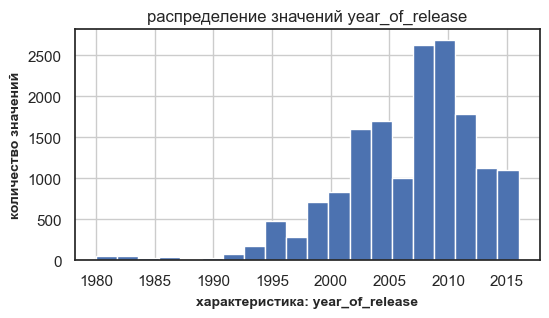

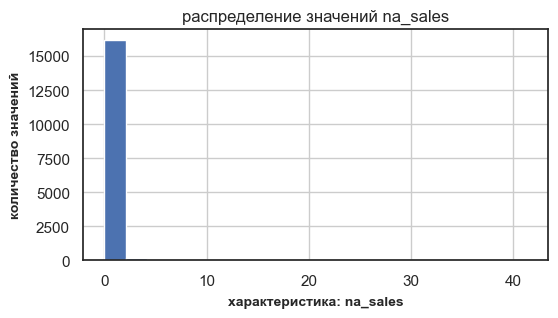

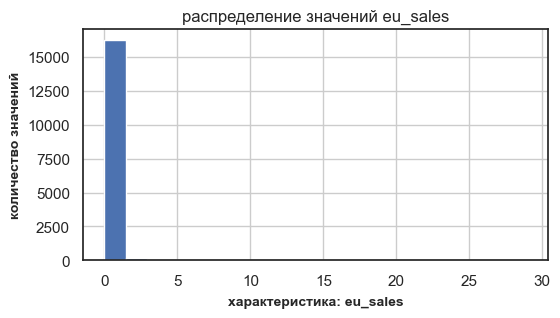

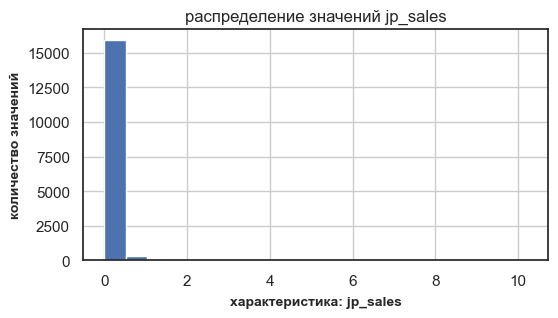

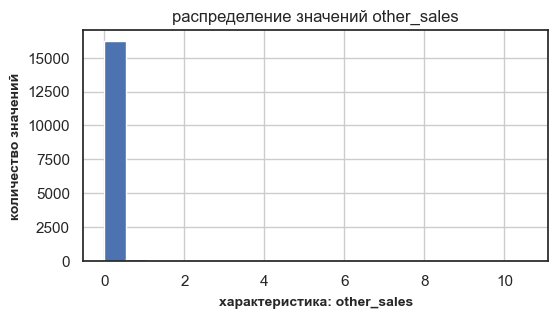

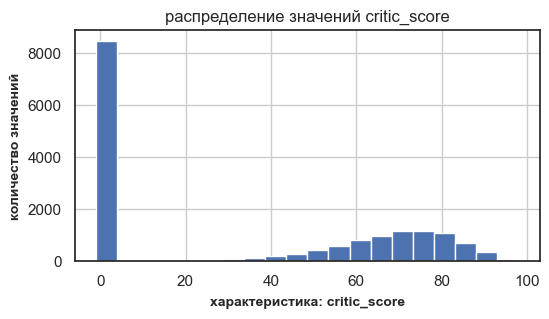

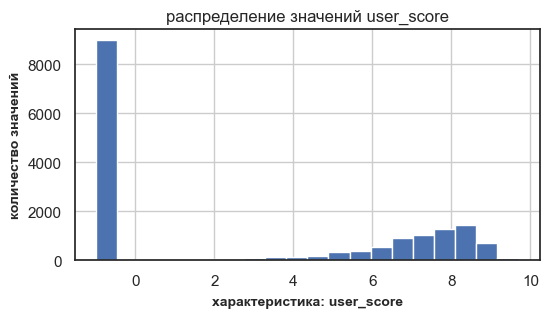

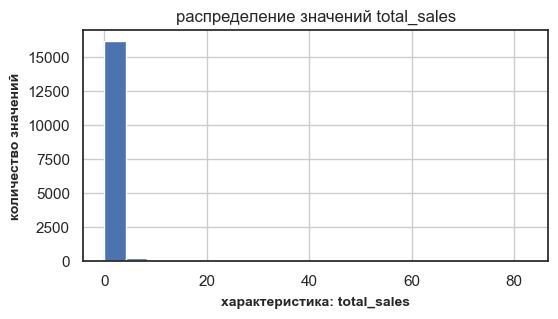

In [59]:
columns = data.columns.tolist()

for column in columns:
    if data.dtypes[column] == object:
        pass
    else:
        data[column].hist(bins=20, figsize=(6, 3))
        plt.title(f'распределение значений {column}')
        plt.xlabel(f'характеристика: {column}', 
                   fontsize=10, fontweight='bold', labelpad=6)
        plt.ylabel('количество значений', fontsize=10, fontweight='bold')
        plt.show()



распределение данных в целом выглядит ожидаемым: сравнительно скромное количество игр до 1995 с последующим ростом, после которого следует спад и стабилизация рынка. по графикам продаж в различных регионах можно сказать о наличии выбросов. оценки критиков близки к нормальному распределению, а гистограммы оценок пользователей нет, что ожидаемо, т.к. столбец имеет клас object. далее в ходе исследования мы очистим данные и проанализируем распределение этих характеристик.

датасет содержит 1675 наблюдений с 11 характеристиками, которые помогут нам исследовать рынок. отталкиваясь от общей информации о датасете, определим план предобработки данных:
1. скорректируем название столбцов
2. преобразуем типы данных для года выпуска игры.
3. изучим пропуски в каждом столбце
4. проверим датасет на наличие дубликатов
5. добавим информацию об общих продажах для каждой игры.

## 2. Предобработка данных
### 2.1. шапка таблицы и типы данных
приведём названия столбцов к единообразию стиля: заменим все прописыне буквы на строчные.

In [4]:
data.columns = map(str.lower, data.columns)
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


в столбце `year_of_release` сменим тип данных с float на int, так как дробной части год выпуска тметь не может:

In [5]:
data = data.astype({"year_of_release": "Int64"})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  Int64  
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.4+ MB


в столбце `user_score` данные имеют тип object, вероятно, помимо чисел там есть строки. давайте посмотрим на уникакльные значения столбца:

In [6]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

так и есть, среди численных значений затесалось `tbd`. пока оставитм без изменений. далее, на этапе обработки пропусков, мы примем решение об удалении, либо замене этогой оценки на число. после устранения строковых данных мы поменяем тип `object` на `float64`

### 2.2. работа с дубликатами
проверим наблюдения в датасете на совпадения по ключевым параметрам: название, платформа и год выпуска игры. в случае, если будут обнаружены дубли, у которых при этом есть расхождения в продажах, имеет смысл объединить наблюдения, просуммировав продажи.

In [7]:
print(data[data.duplicated(['name', 'platform', 'year_of_release'])].count())
           
data[data.duplicated(['name', 'platform', 'year_of_release'], keep=False)].sort_values('name')

name               1
platform           2
year_of_release    2
genre              1
na_sales           2
eu_sales           2
jp_sales           2
other_sales        2
critic_score       1
user_score         1
rating             1
dtype: int64


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
604,Madden NFL 13,PS3,2012,Sports,2.11,0.22,0.00,0.23,83.0,5.5,E
16230,Madden NFL 13,PS3,2012,Sports,0.00,0.01,0.00,0.00,83.0,5.5,E
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


всего две записи об играх, дублирующиеся по ключевым характеристикам. при этом одно из наблюдений &mdash; игра без названия, жанра, оценок и почти без продаж. удалим оба наблюдения. к оставшемуся дублю записи с инексом 14244 вернёмся в ходе работы с пропусками.

In [8]:
data.at[604, 'eu_sales'] = 0.23
data = data.drop_duplicates(['name', 'platform', 'year_of_release'])


print(f"{data.info()} \n \n"
      f"количество повторов:\n{data[data.duplicated(['name', 'platform', 'year_of_release'])].count()}"
     )


<class 'pandas.core.frame.DataFrame'>
Index: 16713 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16713 non-null  object 
 2   year_of_release  16444 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16713 non-null  float64
 5   eu_sales         16713 non-null  float64
 6   jp_sales         16713 non-null  float64
 7   other_sales      16713 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB
None 
 
количество повторов:
name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score        

### 2.3. работа с пропущенными значениями
перед тем как начать работать с пропущенными значениями, оценим долю пропусков в каждом столбце и зафиксируем в отдельной таблице:

In [9]:
missing_data_start = data.isna().sum().to_frame().rename(columns = {0: 'missing_values_start'})

missing_data_start['total_values_start'] = data.shape[0]
missing_data_start['% of total_start'] = (missing_data_start['missing_values_start'] / data.shape[0] * 100).round(2)

missing_data_start.sort_values('missing_values_start', ascending = False)

,missing_values_start,total_values_start,% of total_start
critic_score,8577,16713,51.32
rating,6765,16713,40.48
user_score,6700,16713,40.09
year_of_release,269,16713,1.61
name,1,16713,0.01
genre,1,16713,0.01
platform,0,16713,0.00
na_sales,0,16713,0.00
eu_sales,0,16713,0.00
jp_sales,0,16713,0.00


#### 2.3.1. NAME & GENRE

в столбцах `name` и `genre` меньше всего пропусков: **0.01%** от общего числа наблюдений &mdash; это один объект, оставшийся от чистки дубликатов. посмотрим на него перед удалением:

In [10]:
data.query('name.isna() or genre.isna()')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.0,0.08,NaN,NaN,NaN


так же, как и строка с индексом 14244, это наблюдение имеет пропуски в ключевых для нашего исследования показателях. удалим его их основного датасета:

In [11]:
data = data.query('name.notna()')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16712 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16712 non-null  object 
 1   platform         16712 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16712 non-null  object 
 4   na_sales         16712 non-null  float64
 5   eu_sales         16712 non-null  float64
 6   jp_sales         16712 non-null  float64
 7   other_sales      16712 non-null  float64
 8   critic_score     8136 non-null   float64
 9   user_score       10013 non-null  object 
 10  rating           9948 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB


#### 2.3.2. YEAR_OF_RELEASE
также мы видим большее, но по-прежнему некритичное количество пропусков (**1.61%**) в столбце `year_of_release`. для начала посмотрим, можем ли мы для восстановления года выхода воспользоваться информацией о дате выхода данной игры на других консолях. составим сводную таблицу, в которой для каждого уникального значения в `names` подсчитаем количество различных годов публикации.

In [12]:
releases = (data.pivot_table(index='name', 
                    values='year_of_release', 
                    aggfunc=pd.Series.nunique)
            .sort_values('year_of_release', ascending=False)
            .rename(columns = {'year_of_release': 'years_count'})
            .reset_index()
           )

print(f"Распределение игр по вариантивности дат выпуска на разных платформах: \n"
      f"{releases['years_count'].value_counts()}"
     )
releases

Распределение игр по вариантивности дат выпуска на разных платформах: 
years_count
1    10732
2      633
0      133
3       49
4       10
5        2
Name: count, dtype: Int64


,name,years_count
0,SimCity 2000,5
1,Monopoly,5
2,Jeopardy!,4
3,Warriors Orochi 3,4
4,NBA Jam,4
...,...,...
11554,Swords,0
11555,Charm Girls Club: My Fashion Mall,0
11556,Charm Girls Club: My Fashion Show,0
11557,Sword of the Samurai,0


доля игр, у которых релиз на разных платформах состоялся в разные годы, не велика, однако вариативность всё же присутствует. так как на данный момент у нас нет возможности уточнить дату релиза для каждого проблемного наблюдения, стоит удалить такие строки. потеря 1.61% выброки не скажется на репрезентативности.

In [13]:
data = data.query('year_of_release.notna()')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     7982 non-null   float64
 9   user_score       9838 non-null   object 
 10  rating           9767 non-null   object 
dtypes: Int64(1), float64(5), object(5)
memory usage: 1.5+ MB


#### 2.3.3. RATING
`rating		40.48%`  
в датасете **40%** наблюдений, для которых не указан рейтинг. заполнять пустоты наиболее частотными значениями в пределах жанра для каждой платформы нецелесообразно: мы не располагаем характеристиками игр, а также нам неизвестны критерии, по которым происходит оценка. заменим пропущенные значения на `unknown`:

In [14]:
data['rating'] = data['rating'].fillna('unknown')
data['rating'].value_counts()

rating
unknown    6676
E          3920
T          2905
M          1536
E10+       1393
EC            8
K-A           3
AO            1
RP            1
Name: count, dtype: int64

#### 2.3.4. CRITIC_SRORE
`critic_score	51.32%`  
столбец с самым значительным количеством пропусков, заменять которые медианой или средним нецелесообразно. перед тем, как принимать решение о дальнейшей судьбе столбца, давайте изучим данные об играх, оставшихся без оценки: для каждого года подсчитаем количество игр без оценки, общее количество игр и найдём долю, которую составляют от общего игры без оценки

In [15]:
# создадим вспомогательный датасет, в который поместим игры без оценки критиков
no_critic = (data.query('critic_score.isna()')
             .pivot_table(index='year_of_release',   # строками назначим годы релиза
                          values='name',             
                          aggfunc='count',           # подсчитаем количество упоминаний
                          fill_value=0               # заменим пустоты нулями
                         )
             .rename(columns = {'name': 'quantity'})
             )

# создадим вспомогательный датасет, в которы поместим все игры
games_by_year = (data.pivot_table(index='year_of_release',
                                  values='name', 
                                  aggfunc='count',
                                  fill_value=0
                                  )
             .rename(columns = {'name': 'total_quantity'})
             )

# объединим полученные датасеты в общую таблицу и посчитаем долю игр без рейтинга:
no_critic_compare = no_critic.join(games_by_year, how='outer')
no_critic_compare['%_of_total'] = (no_critic_compare['quantity'] 
                                   / no_critic_compare['total_quantity'] * 100).round(2)
no_critic_compare

,quantity,total_quantity,%_of_total
year_of_release,,,
1980,9,9,100.00
1981,46,46,100.00
1982,36,36,100.00
1983,17,17,100.00
1984,14,14,100.00
1985,13,14,92.86
1986,21,21,100.00
1987,16,16,100.00
1988,14,15,93.33


мы видим, что внушительное количество пропусков в первую очередь объясняется тем, что до 1996 года, скорее всего, не было практики оценки игр. начиная с 1996 года мы наблюдаем увеличение количества игр, получивших оценку от критиков. начиная с 2000 года, можно говорить о налаженном процессе оценки игр. количество пропусков по-прежнему остаётся существенным, что, вероятно, объясняется тем, что далеко не каждая игра может привлечь внимание критиков.  
заменим пропуски значением, которое будет явно отличаться от реальных оценок пользователей:

In [16]:
data['critic_score'] = data['critic_score'].fillna(-1)

print(f"Количество пропусков в столбце critic_score: {data['critic_score'].isna().sum()}")

Количество пропусков в столбце critic_score: 0


#### 2.3.5. USER_SCORE
`user_score	    40.09%`  
так же, как и в случае с оценкой критиков, сначала посмотрим, как менялось внимание игроков с течением времени: сведём в одной таблице информацию о количестве отзывов, количестве игр и доле игр с отзывами от года к году:

In [17]:
# вспомогательный датасет с наблюдениями без пользовательских оценок:
no_user = (data.query('user_score.isna()')
             .pivot_table(index='year_of_release',
                          values='name', 
                          aggfunc='count',
                          fill_value=0
                         )
             .rename(columns = {'name': 'quantity'})
             )

# объединим вспомогательный датасет с games_by_year, который мы создали на предыдущем этапе.
no_user_compare = no_user.join(games_by_year, how='outer')
no_user_compare['%_of_total'] = (no_user_compare['quantity'] 
                                   / no_user_compare['total_quantity'] * 100).round(2)
no_user_compare

,quantity,total_quantity,%_of_total
year_of_release,,,
1980,9,9,100.00
1981,46,46,100.00
1982,36,36,100.00
1983,17,17,100.00
1984,14,14,100.00
1985,13,14,92.86
1986,21,21,100.00
1987,16,16,100.00
1988,14,15,93.33


поведение пользователей повторяет поведение критиков: начиная с 1996 года количество оценок постепенно растёт, а к 2000 году процесс стабилизируется. как и в случае с критиками, заменим пропуски уникальным значением, которе будет отличаться от реальных оценок:

In [18]:
data['user_score'] = data['user_score'].fillna(-1)

print(f"Количество пропусков в столбце user_score: {data['critic_score'].isna().sum()}")

Количество пропусков в столбце user_score: 0


среди оценок пользователей есть строковое значение `tbd` (to be definied), то есть на момент выгрузки данных сбор оценок пользователей ещё не был завершён. в рамках нашего проекта данное значение можно приравнять к пропуску, так как мы не можем сопоставить его с другими численными значениями:

In [19]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = -1
data['user_score'] = data['user_score'].astype('float64')
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16443 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16443 non-null  object 
 1   platform         16443 non-null  object 
 2   year_of_release  16443 non-null  Int64  
 3   genre            16443 non-null  object 
 4   na_sales         16443 non-null  float64
 5   eu_sales         16443 non-null  float64
 6   jp_sales         16443 non-null  float64
 7   other_sales      16443 non-null  float64
 8   critic_score     16443 non-null  float64
 9   user_score       16443 non-null  float64
 10  rating           16443 non-null  object 
dtypes: Int64(1), float64(6), object(4)
memory usage: 1.5+ MB


прежде чем подводить промежуточный итог, оценим потери датасета: сравним показатели на старте и в конце предобработки данных:

In [20]:
missing_data_final = data.isna().sum().to_frame().rename(columns = {0: 'missing_values_final'})

missing_data_final['total_values_final'] = data.shape[0]
missing_data_final['% of total_final'] = (missing_data_final['missing_values_final'] / data.shape[0] * 100).round(2)


missing_data_final = missing_data_start.join(missing_data_final)

missing_data_final['% data_loss'] = (((missing_data_final['total_values_start']
                                       - missing_data_final['total_values_final'])
                                      / missing_data_final['total_values_start'] * 100)
                                     .round(2)
                                    )
                                    
missing_data_final

,missing_values_start,total_values_start,% of total_start,missing_values_final,total_values_final,% of total_final,% data_loss
name,1,16713,0.01,0,16443,0.0,1.62
platform,0,16713,0.00,0,16443,0.0,1.62
year_of_release,269,16713,1.61,0,16443,0.0,1.62
genre,1,16713,0.01,0,16443,0.0,1.62
na_sales,0,16713,0.00,0,16443,0.0,1.62
eu_sales,0,16713,0.00,0,16443,0.0,1.62
jp_sales,0,16713,0.00,0,16443,0.0,1.62
other_sales,0,16713,0.00,0,16443,0.0,1.62
critic_score,8577,16713,51.32,0,16443,0.0,1.62
user_score,6700,16713,40.09,0,16443,0.0,1.62


**Промежуточный итог**  

в результате подготовки данных к исследованию мы смогли полностью избавиться от пропущенных значений, при этом потеря данных составила всего **1.62%**. что мы сделали в рамках предобработки:  
1. привели названия столбцов к корректному стилю
2. выявили и удалили два дубликата
3. удалили игры, у которых не было указано название и жанр
4. приняли решение удалить 269 наблюдений, для которых не был указан год. дата релиза является ключевым параметром для нашего исследования, а значит, заполнение пропусков усреднёнными значениями может оказать существенное влияние на статистический анализ и проверку гипотез.
5. 40% пропусков в столбце рейтинг мы заполнили значением `unknown`. как и в случае с годом выпуска, мы пришли к выводу, что искусственное заполнение пустот наиболее частотными значениями окажет негативное влияние на качество данных.
6. мы выяснили, что до 1996 года оценкой игр не занимались стабильно ни пользователи, ни критики и что процесс оценки стал стабильным примерно в 2000 году. наличие пропусков в данном случае можно объяснить как ошибками в сборе и парсинге данных, так и тем, что количество игр на рынке значительно превышает количество желающих выставить оценку, не все игры привлекают внимание пользователей и критиков. в обоих случаях мы заменили пустоты на -1 &mdash; численное значение, которое явно отличается от реального рейтинга.

### 2.4. Подсчёт суммарного показателя продаж

для дальнейшего исследования нам нонадобится информация о том, сколько копий игры было продано по всему миру. мы уже очистили данные, добавим последний штрих:

In [21]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
data.sort_values('total_sales', ascending=False).head(15)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,-1.0,-1.0,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,-1.0,-1.0,unknown,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,-1.0,-1.0,unknown,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,-1.0,-1.0,unknown,28.31


наш датасет полностью готов к исследовательскому анализу данных.

## 3. Исследовательский анализ данных
для понимания особенностей рынка компьютерных игр, исследуем датасет в разрезе основных ключевых характеристик:
* динамика выпуска игр от года к году
* популярность игровых платформ от года к году
* вычленение актуального периода продаж
* определение лидеров продаж среди платформ
* выявление платформ, теряющих популярность
* выявление зависимости уровня продаж от оценок критиков и пользователей
* определение самых прибыльных игровых жанров

### 3.1. Динамика выпуска игр от года к году
подготовим сводную таблицу, где в строках будет отображаться годы выпуска игр, а в столбце &mdash; суммарное количество проданных копий для всех платформ.

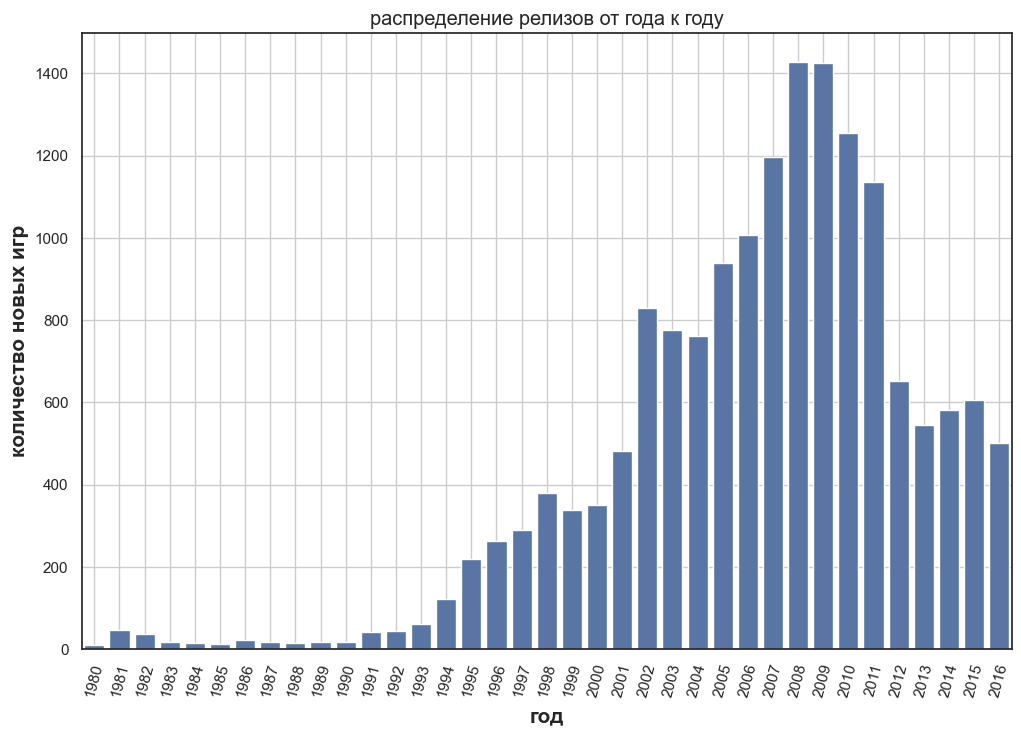

In [61]:
quantity = (data.pivot_table(index='year_of_release', values='total_sales', aggfunc='count')
            .rename(columns = {'total_sales': 'quantity'})
            .reset_index()
           )
 

sns.barplot(data=quantity, x='year_of_release', y='quantity')
sns.set_theme(rc={'figure.figsize': (17, 9)}, style='white')
sns.set(font_scale=1.2)
plt.title('распределение релизов от года к году')
plt.xlabel('год', fontsize=15, fontweight='bold', labelpad=6)
plt.ylabel('количество новых игр', fontsize=15, fontweight='bold')
plt.xticks(rotation=75)
plt.grid(True)
plt.show()

график отображает появление на рынке новых игр в период с 1980 по 2016: начиная с 1994 года начинается ощутимое увеличение количества релизов, которое достигает своего максимума в 2008-2009 годах, после чего начинается спад. в период 2012-2016 наблюдается стабилизация рынка без резких всплесков и спадов. этот период видится нам наиболее благоприятным для дальнейшего исследования по нескольким причинам:
* относительная стабильность рынка
* появление новых игровых платформ (для прогноза нужны намболее актуальные данные по консолям, под которые производят новые игры)
* новые игры вызывают больший интерес у пользователей, тогда как к старым играм, выпущенным 5 лет назад и более, люди возвращаются значительно реже. особенно, если речь идёт о привлечении новых пользователей.

### 3.2. Динамика прибыльности платформ от года к году

посмотрим, как менялись суммарные продажи по платформам от года к году. датасет содержит внушительный промежуток времени: более 30 лет, в течение которых успели взлететь и угаснуть множество игровых консолей. 

для начала визуализируем продажи по платформам, чтобы определить наиболее востребованные консоли.

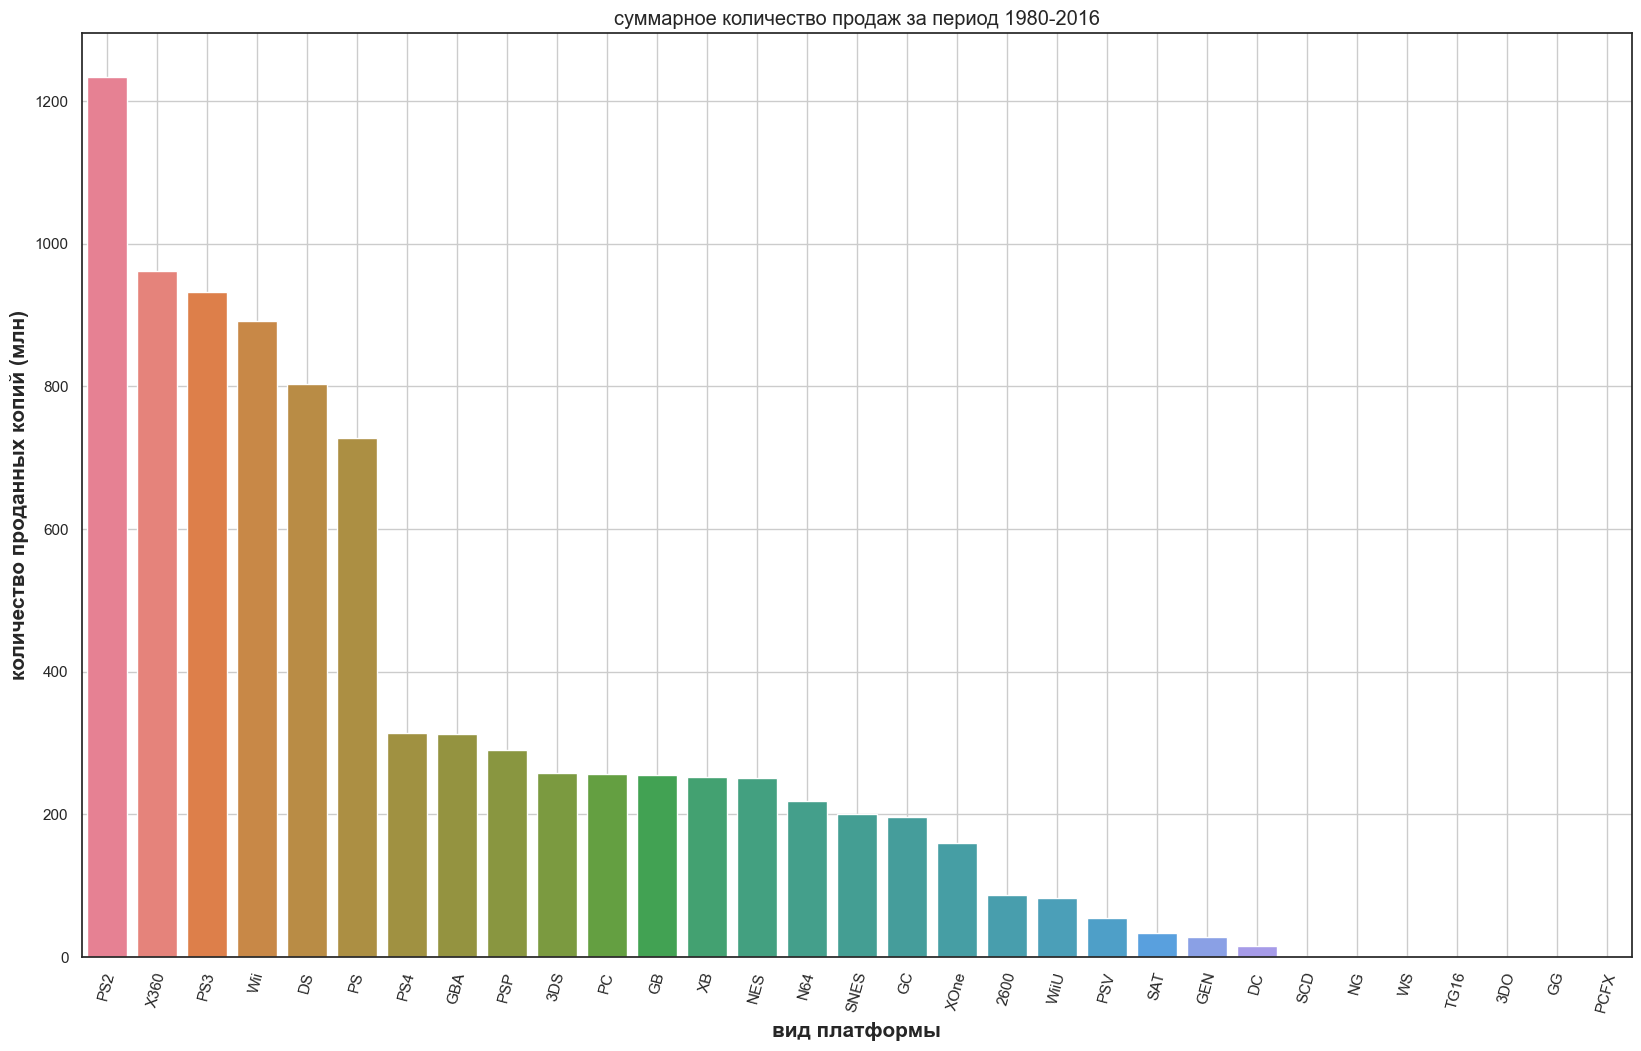

In [63]:
platform_sales = (data.pivot_table(index='platform',
                                  values='total_sales',
                                  aggfunc='sum',
                                  fill_value=0)
                  .reset_index()
                  .sort_values('total_sales', ascending=False)
                 )
sns.set_theme(rc={'figure.figsize':(20, 12)}, style='white')
sns.barplot(data=platform_sales, x='platform', y='total_sales', hue='platform')
sns.set(font_scale=1.2)
plt.title('суммарное количество продаж за период 1980-2016')
plt.xlabel('вид платформы', fontsize=15, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=15, fontweight='bold')
plt.xticks(rotation=75)
plt.grid(True)
plt.show()

на графике весьма наглядно отображён топ-6 платформ, игры которых продавались лучше всего. однако это данные за весь исторический период. давайте посмотрим, как распределены продажи по годам для `PS2`, `X360`, `PS3`, `Wii`, `DS`, `PS`

In [24]:
top = (data.query("platform == ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']")
           .pivot_table(values=['total_sales'],
                        index=['year_of_release'],
                        columns=['platform'],
                        aggfunc='sum', 
                     fill_value=0)
          )
top

total_sales                                        
platform                 DS      PS     PS2     PS3     Wii    X360
year_of_release                                                    
1985                   0.02    0.00    0.00    0.00    0.00    0.00
1994                   0.00    6.03    0.00    0.00    0.00    0.00
1995                   0.00   35.96    0.00    0.00    0.00    0.00
1996                   0.00   94.70    0.00    0.00    0.00    0.00
1997                   0.00  136.17    0.00    0.00    0.00    0.00
1998                   0.00  169.49    0.00    0.00    0.00    0.00
1999                   0.00  144.53    0.00    0.00    0.00    0.00
2000                   0.00   96.37   39.17    0.00    0.00    0.00
2001                   0.00   35.59  166.43    0.00    0.00    0.00
2002                   0.00    6.67  205.38    0.00    0.00    0.00
2003                   0.00    2.07  184.31    0.00    0.00    0.00
2004                  17.27    0.00  211.81    0.00    0.00    0.00
2005                 130.14    0.00  160.66    0.00    0.00    8.25
2006                 119.81    0.00  103.42   20.96  137.15   51.62
2007                 146.94    0.00   75.99   73.19  152.77   95.41
2008                 145.31    0.00   53.90  118.52  171.32  135.26
2009                 119.54    0.00   26.40  130.93  206.97  120.29
2010                  85.02    0.00    5.64  142.17  127.95  170.03
2011                  26.18    0.00    0.45  156.78   59.65  143.84
2012                  11.01    0.00    0.00  107.36   21.71   99.74
2013                   1.54    0.00    0.00  113.25    8.59   88.58
2014                   0.00    0.00    0.00   47.76    3.75   34.74
2015                   0.00    0.00    0.00   16.82    1.14   11.96
2016                   0.00    0.00    0.00    3.60    0.18    1.52

в сводной таблице привлекаюет внимание два момента:
1. продажи для платформы `DS` в 1985 году, по всей видимости, ошибочные: известно, что консоль Nintendo DS была выпущена в 2004 году.
2. популярная платформа `PS` не попадает в наш актуальный период 2012-2016. оставим её в таблице для лучшего представляения о времени жизни платформ, но также добавим наиболее молодые платформы: их общий показатель продаж будет ниже, чем у ветеранов, но для прогнозирования дальнейшего периода они нам понадобятся.  

сначала проверим выброс для консоли DS:

In [25]:
data.query("platform == 'DS' and year_of_release == 1985")

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
15957,Strongest Tokyo University Shogi DS,DS,1985,Action,0.0,0.0,0.02,0.0,-1.0,-1.0,unknown,0.02


данные об этой игре во внешних источниках скудные и разнятся: где-то указано, что игра, действительно, была выпущена в 1985 году, где-то &mdash; в 2007 или в 2010. удалим этот выброс, тем более, что большая часть данных по этому наблюдению отсутствует.

In [26]:
data = data.drop(index=15957)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16442 entries, 0 to 16714
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16442 non-null  object 
 1   platform         16442 non-null  object 
 2   year_of_release  16442 non-null  Int64  
 3   genre            16442 non-null  object 
 4   na_sales         16442 non-null  float64
 5   eu_sales         16442 non-null  float64
 6   jp_sales         16442 non-null  float64
 7   other_sales      16442 non-null  float64
 8   critic_score     16442 non-null  float64
 9   user_score       16442 non-null  float64
 10  rating           16442 non-null  object 
 11  total_sales      16442 non-null  float64
dtypes: Int64(1), float64(7), object(4)
memory usage: 1.6+ MB


перед тем как обновить сводную таблицу для визуализации, посмотрим, у каких платформ были продажи в 2016 году, чтобы добавить в подборку новые консоли:

In [27]:
data.query("year_of_release == 2016")['platform'].unique()

array(['PS4', '3DS', 'XOne', 'WiiU', 'PS3', 'PC', 'X360', 'PSV', 'Wii'],
      dtype=object)

сравним их с нашим изначальным списком и отобразим элемены, которые нужно добавить:

In [28]:
set_1 = data.query("year_of_release == 2016")['platform'].unique()
set_2 = ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS']

set_3 = []
for i in set_1:
    if i not in set_2:
        set_3.append(i)
print(set_3)

['PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']


сведем заново нашу таблицу, чтобы устранить из неё удалённое наблюдение, а также добавить ещё шесть платформ:

In [29]:
top = (data.query("platform == ['PS2', 'X360', 'PS3', 'Wii', 'DS', 'PS', 'PS4', '3DS', 'XOne', 'WiiU', 'PC', 'PSV']")
           .pivot_table(values=['total_sales'],
                        index=['year_of_release'],
                        columns=['platform'],
                        aggfunc='sum', 
                        fill_value=0)
          )
top.head(10)

total_sales                                                 \
platform                3DS   DS     PC      PS    PS2  PS3  PS4  PSV  Wii   
year_of_release                                                              
1985                    0.0  0.0   0.04    0.00   0.00  0.0  0.0  0.0  0.0   
1988                    0.0  0.0   0.03    0.00   0.00  0.0  0.0  0.0  0.0   
1992                    0.0  0.0   3.03    0.00   0.00  0.0  0.0  0.0  0.0   
1994                    0.0  0.0  12.87    6.03   0.00  0.0  0.0  0.0  0.0   
1995                    0.0  0.0   4.22   35.96   0.00  0.0  0.0  0.0  0.0   
1996                    0.0  0.0  10.58   94.70   0.00  0.0  0.0  0.0  0.0   
1997                    0.0  0.0  11.27  136.17   0.00  0.0  0.0  0.0  0.0   
1998                    0.0  0.0   3.26  169.49   0.00  0.0  0.0  0.0  0.0   
1999                    0.0  0.0   4.74  144.53   0.00  0.0  0.0  0.0  0.0   
2000                    0.0  0.0   4.66   96.37  39.17  0.0  0.0  0.0  0.0   

                                
platform        WiiU X360 XOne  
year_of_release                 
1985             0.0  0.0  0.0  
1988             0.0  0.0  0.0  
1992             0.0  0.0  0.0  
1994             0.0  0.0  0.0  
1995             0.0  0.0  0.0  
1996             0.0  0.0  0.0  
1997             0.0  0.0  0.0  
1998             0.0  0.0  0.0  
1999             0.0  0.0  0.0  
2000             0.0  0.0  0.0

теперь всё корректно, можно визуализировать распределение продаж. для большей наглядности используем хитмэп:

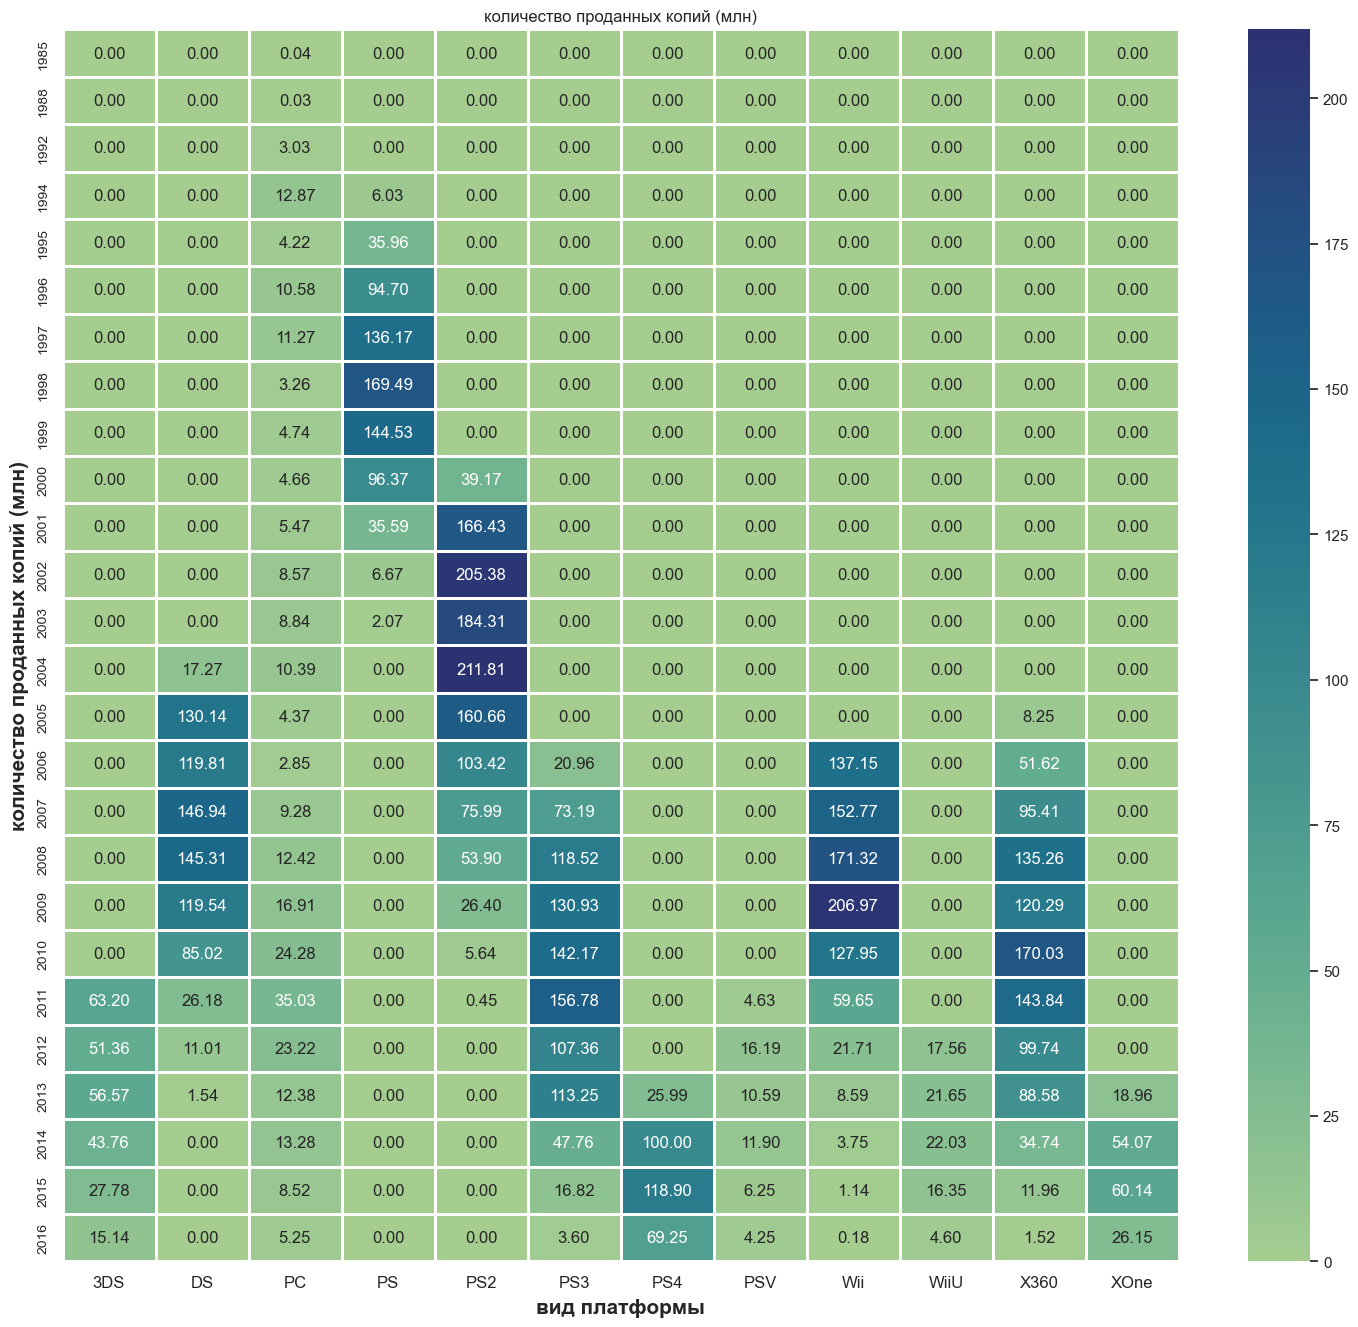

In [30]:
plt.figure(figsize=(18,16))
ax = sns.heatmap(top['total_sales'],linewidths=.8, annot=True, fmt='.2f', cmap="crest")
ax.set_yticklabels(ax.get_yticklabels(), va='center')
plt.title('количество проданных копий (млн)')
plt.xlabel('вид платформы', fontsize=15, fontweight='bold', labelpad=6)
plt.xticks(size=12)
plt.ylabel('количество проданных копий (млн)', fontsize=15, fontweight='bold', labelpad=6)
plt.yticks(size=10)
plt.show()

рассчитаем медианное значение срока жизни платформы, для того чтобы выделить ключевые платформы для прогнозирования продаж в следующем сзоне:

In [31]:
time_life = data.pivot_table(index='platform', 
                             values='year_of_release', 
                             aggfunc=['min', 'max']).reset_index()

time_life
time_life['life'] = time_life['max'] - time_life['min'] + 1 # в срок жизни платформы, должны входить границы диапазона, 
                                                            # поэтому +1
time_life['life'].median()

7.0

медианный срок жизни платформы составляет 7 лет. у нас на хитмэпе отображён долгожитель `PC`: 32 года на рынке игр, общие продажи от года к году не так высоки, как у консолей, однако тут заметны стабильные колебания: от плавного роста к плавному спаду.  

добавление новых позиций помогло нам выявить молодую платформу `PS4`, которая демонстрирует неплохие продажи. 

любопытно то, что некоторые консоли берут резкий старт (`Wii` &mdash; 137.15 млн копий в год релиза платформы), но в целом требуется 2-3 года, чтобы набрать оброты. и почти во всех случаях наименее результативными являются последние три года жизни. следует учесть это в планировании рекламных кампаний.  

у консоли `PS4` наблюдается резкий спад на четвёртом году: в период, когда, казалось бы, продажи должны быть на пике. это может быть связано с тем, что 2016 год представлен в датасете не полностью: этот спад наблюдается у всех платформ.

**Промежуточный вывод**

исхродя из распределения количества выпускаемых игр по годам и суммарного количества игр для каждой платформы, можно сделать следующее заключение:
* актуальным периодом для исследования является промежуток 2012-2016 годов: период стабилизации рынка достаточный, чтобы можно было исследовать динамику популярности различных игровых жанров, но при этом не слишком продолжительный, не затрагивающий морально устарешие игры.
* на игровом рынке есть шесть брендов платформ, на которые стоит обратить внимание: большая часть игр разрабатывается именно для этих платформ.
* продолжительность жизни игровой платформы &mdash; 7 лет, а для "разгона" может потребоваться 2-3 года
* для исследования рынка в актуальном периоде 2012-2016 возьмём продажи по следующим платформам: `3DS`, `PS3`, `PS4`, `X360`, `XOne`. прочие платформы &mdash; либо уходящие ветераны, либо "не выстрелившие" новинки, их лучше отложить в сторону. платформу `PC` нужно рассматривать в отдельном порядке: её период жизни значительно дольше и динамика продаж отличается от платформ-консолей.

### 3.3. распределение продаж
исследуем, каким образом распределены глобальные продажи в промежутке 2012-2016

In [32]:
# отсечём и сохраним вспомогательный датасет, который будет включать наблюдения в промежутке 2012-2016:
fresh_data = data.query("year_of_release > 2011")
fresh_data.head(15)
fresh_data['year_of_release'].unique()

<IntegerArray>
[2013, 2015, 2012, 2014, 2016]
Length: 5, dtype: Int64

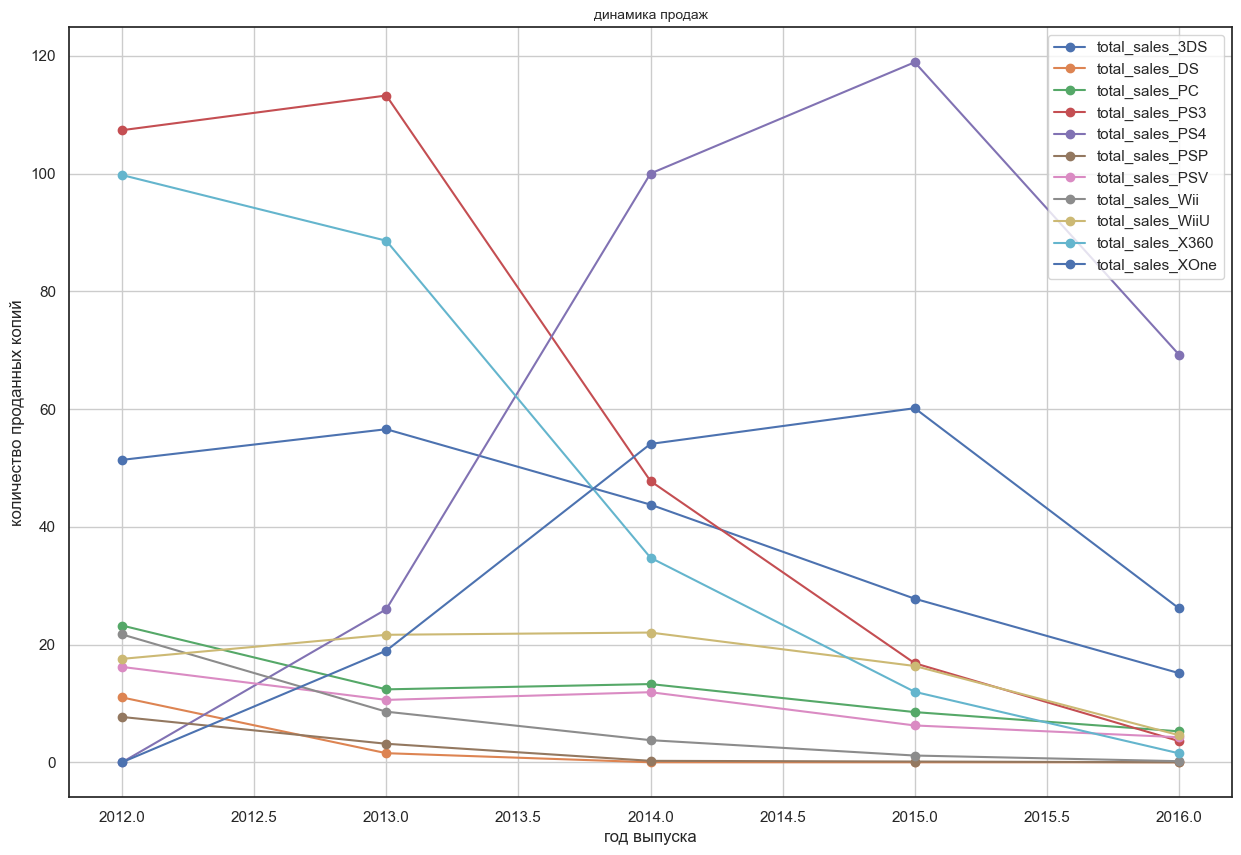

In [33]:
fresh_data_pivot = fresh_data.pivot_table(values=['total_sales'], 
                                          index=['year_of_release'],
                                          columns=['platform'], 
                                          aggfunc='sum', 
                                          fill_value=0)

fresh_data_pivot.columns = ['_'.join(str(s).strip() for s in col if s) for col in fresh_data_pivot.columns]


fresh_data_pivot.plot(style='o-', figsize=(15, 10))
plt.title(f'динамика продаж', fontsize=10)
plt.ylabel('количество проданных копий')
plt.xlabel('год выпуска')
plt.grid(True)
plt.legend()
plt.show()


график отображает динамику продаж платформ за 2012-2016 годы.
* наблюдаемый рост: `PS4` и `XOne`
* стремительное педение: `PS3`, `X360`, `3DS`  

прочие платформы демонстрируют постепенное снижение продаж. мы не берём в расчёт снижение продаж по всем платформам в поомежутке 2015-2016 годы, очевидно, данные о продажах были собраны не в конце отчётного периода, что негативно отразилось на динамике всех наблюдений.

исходя из этого в разрезе глобальных продаж мы можем говорить о потенциальной прибыльности двух консолей: PS4 и XOne


для визуализации распределения глобальных продаж за 2012-2016 годы воспользуемся графиком boxplot, который поможет нам оценить и сравнить наиболее важные статистики:

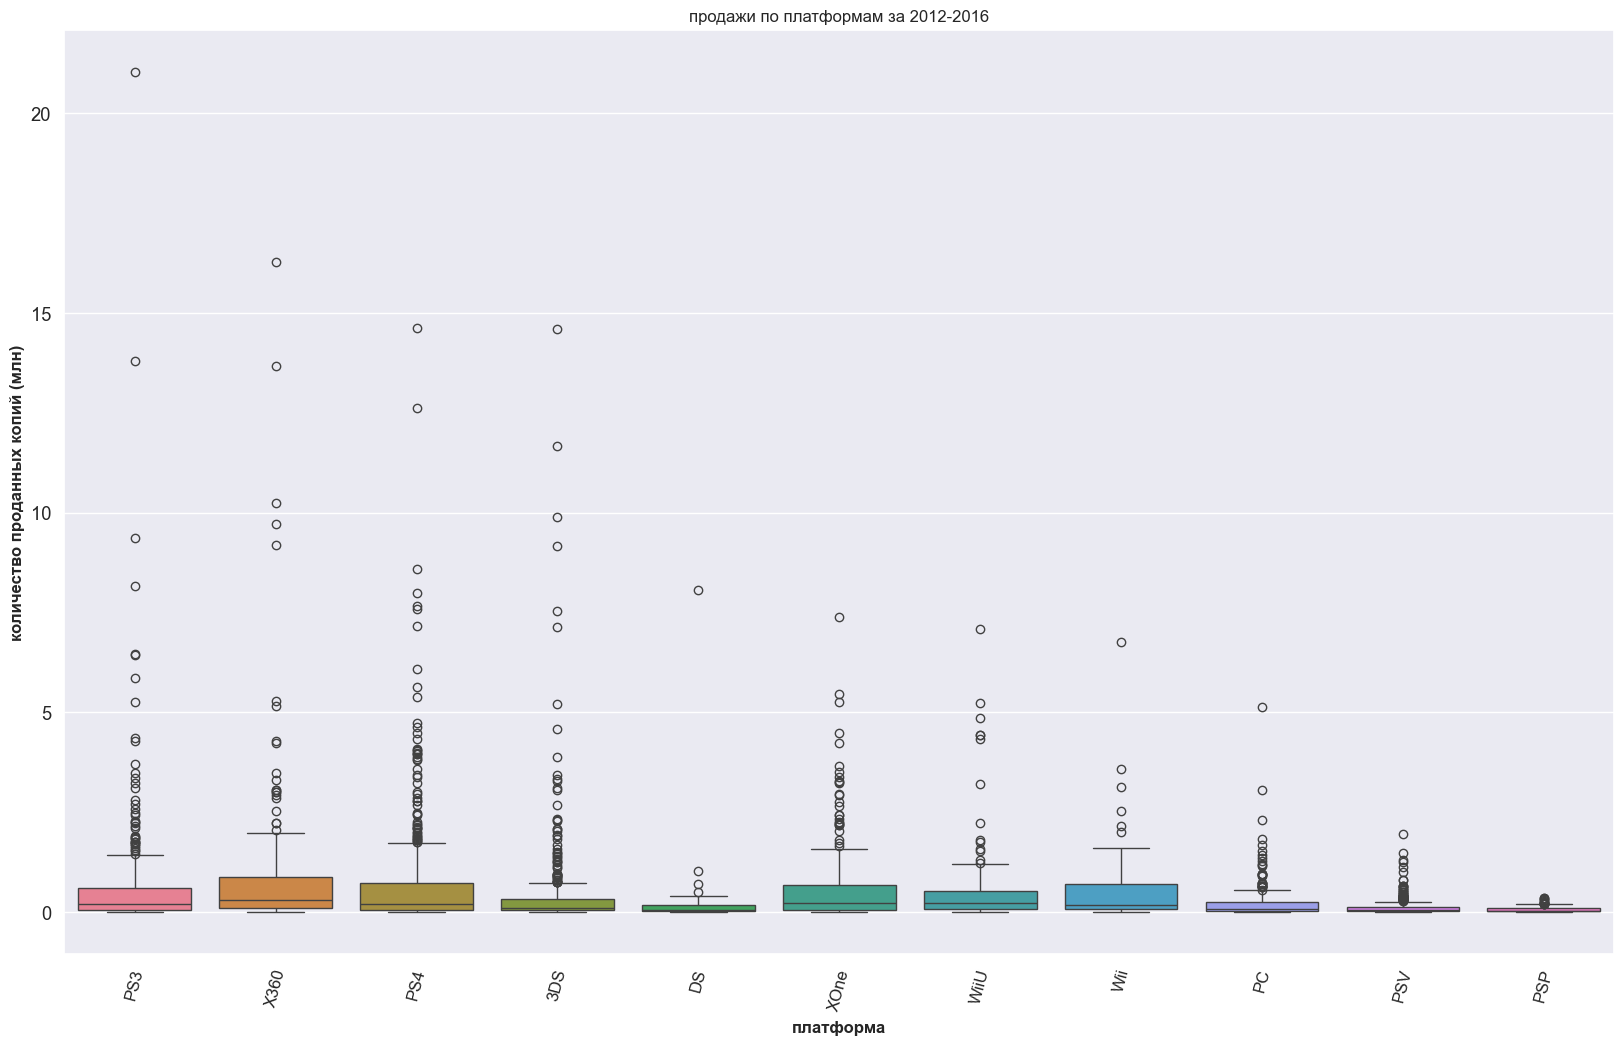

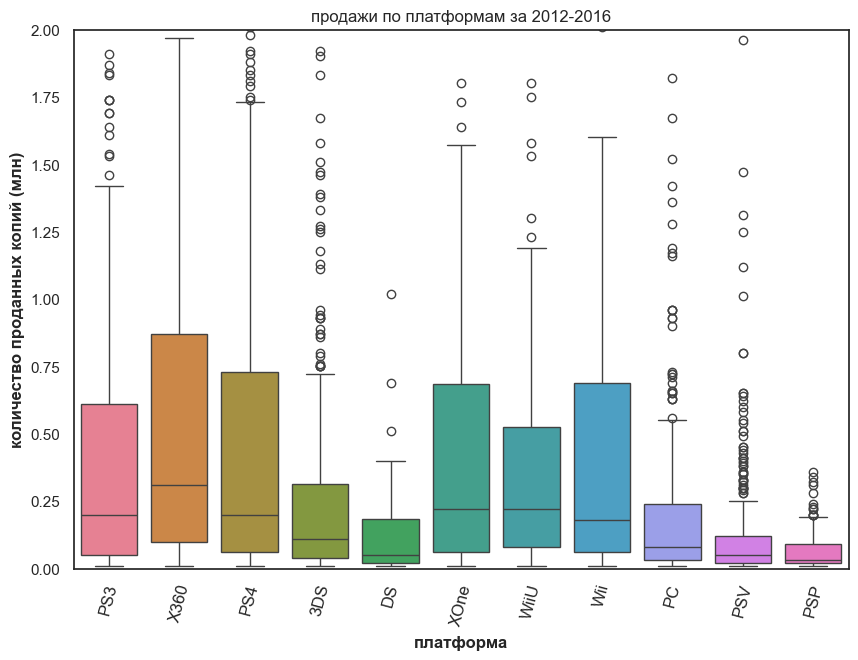

In [64]:
ax = sns.boxplot(data=fresh_data, x='platform', y='total_sales', hue='platform')
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')
plt.title('продажи по платформам за 2012-2016')
plt.xlabel('платформа', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.show()


ax = sns.boxplot(data=fresh_data, x='platform', y='total_sales', hue='platform')
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')
plt.title('продажи по платформам за 2012-2016')
plt.xlabel('платформа', fontsize=12, fontweight='bold', labelpad=6)
plt.ylim(0, 2)
plt.ylabel('количество проданных копий (млн)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.show()

на представленных графиках видно, что наилучшие показатели по продажам (медианное значение, верхний порог выбросов)  у платформы X360, однако если опираться на график, который мы строили выше, актуальный период охватывает финальную стадию жизни консоли, поэтому прогнозировать мощные продажи в 2017 году мы не можем.

на фоне прочих наболее слабые показатели демонстрирует платформа `3DS`: мы изначально видели это на хитмэпе и сейчас подтвердили: медианные продажи у этой консоли в два раза ниже, чем у оставшейся тройки. среди новых платформ, взятых по общему срезу датасета за 2012-2016 годы, так же видим слабые покащатели для платформ `PSV`, `PC` и `PSP`.

`PS3`, `PS4`, `XOne` и `WiiU` &mdash; платформы с примерно одинаковым медианным значением продаж. ондако `PS3` так же, как и `3DS` демонстрирует постепенный спад продаж, что ожидаемо, так как ей на смену выпустили новую `PS4`. пока наиболее перспективными видятся: `PS4` и `XOne` &mdash; обе платформы появились на рынке не так давно. 

так же, глядя на хвост выбросов, имеющийся у каждой консоли, можно говорить о том, что во всех пяти случаях кассу делают несколько популярных игр, количество проданных копий которых больше медианного значения в 7-20 раз. давайте посмотрим, что это за игры.

In [35]:
(fresh_data.pivot_table(index=['name','platform'],
                   values='total_sales',
                   aggfunc='sum')
             .reset_index()
             .sort_values('total_sales', ascending=False)
             .head(10)
 
)

,name,platform,total_sales
950,Grand Theft Auto V,PS3,21.05
952,Grand Theft Auto V,X360,16.27
320,Call of Duty: Black Ops 3,PS4,14.63
1820,Pokemon X/Pokemon Y,3DS,14.60
324,Call of Duty: Black Ops II,PS3,13.79
326,Call of Duty: Black Ops II,X360,13.68
951,Grand Theft Auto V,PS4,12.62
1816,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,11.68
331,Call of Duty: Ghosts,X360,10.24
1677,New Super Mario Bros. 2,3DS,9.90


самыми кассовыми оказались игры *Grand Theft Auto V* (для `PS3` и `X360`), *Call of Duty: Black Ops 3* (`PS4`) и Pokemon X/Pokemon Y (`3DS`). игры платформы `XOne` не попали в топ-10, однако ранее мы уже отмечали отсутствие у этой консоли кассовых игр.  
также следует обратить внимание на два момента:
* конкурирующие производители платформ имеют одинаковых лидеров продаж: например, Grand Theft Auto V или Call of Duty: Black Ops II	
* игра, ставшая хитом на одной платформе, может иметь менее ошеломительный успех на другой платформе.

**Промежуточный вывод**  
на данном этапе исследования мы выяыили особенности мировых продаж игр для пяти консолей: `3DS`, `PS3`, `PS4`, `X360`, `XOne`. из них наиболее успешной выглядит `X360`, однако у нас нет уверенности, что в следующие годы продажи будут держаться на прежнем уровне. наиболее перспективными являются `PS4` и `XOne`.
также мы заметили, разным консолям могут делать кассу одни и те же игры, однако это утверждение зависит от многих коммерческих факторов и требует дополнительной проверки.

### 3.4. влияние оценок на продажи

на этом этапе исследования мы посмотрим, в какой степени оценки пользователей и критиков могут повлиять на продажи. начнём с оценок пользователей.

построим диаграмму рассеяния пользовательских оценок игр для каждой из избранных пяти платформ.

платформа 3DS. корреляция с отзывами:
0.2


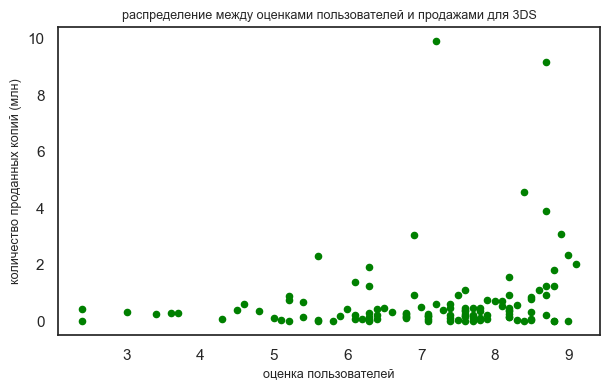

платформа PS3. корреляция с отзывами:
-0.01


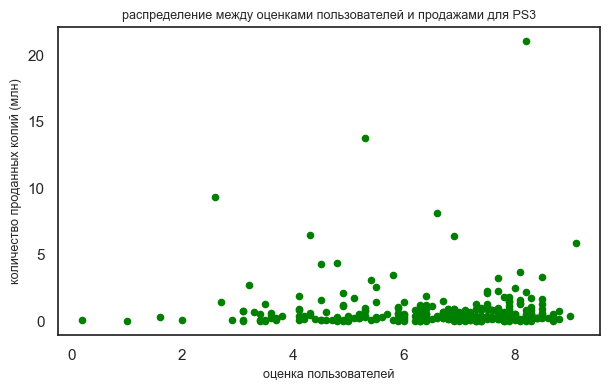

платформа PS4. корреляция с отзывами:
-0.03


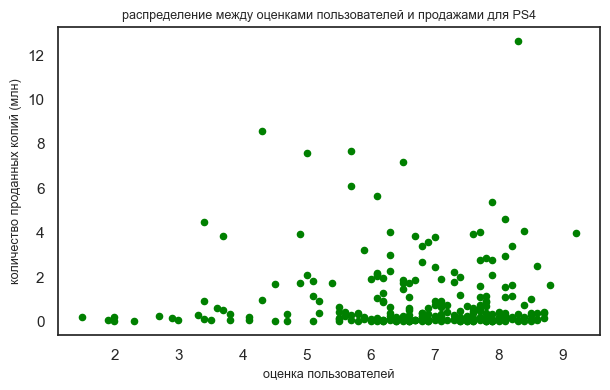

платформа X360. корреляция с отзывами:
0.01


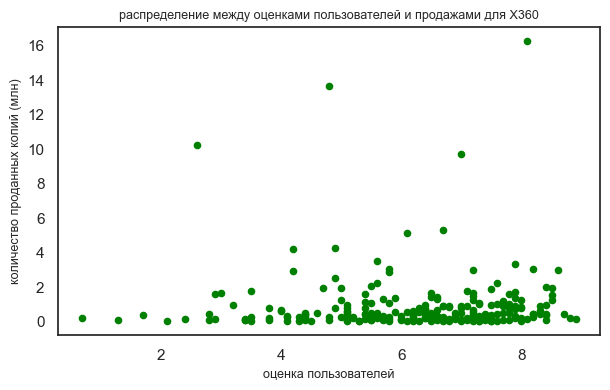

платформа XOne. корреляция с отзывами:
-0.07


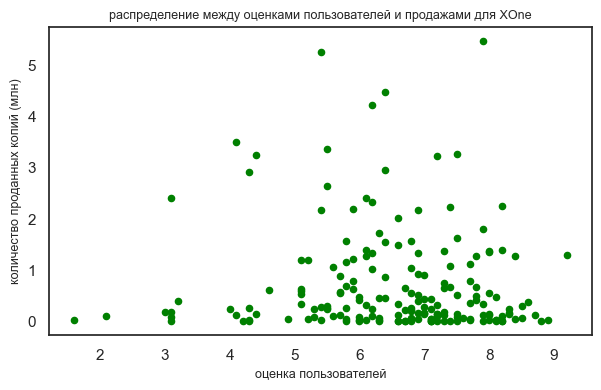

In [36]:
# сохраним молодых в отдельный датасет:
young_5 = ['3DS', 'PS3', 'PS4', 'X360', 'XOne']
young_5_data = data.query("platform in @young_5 and year_of_release > 2011")

for name in young_5:
    (young_5_data.query('platform == @name and user_score > -1')
     .plot(x='user_score', 
           y='total_sales',
           kind='scatter',
           figsize=(7, 4),
           color='green')
    )
    plt.title(f'распределение между оценками пользователей и продажами для {name}', fontsize=9)
    plt.xlabel('оценка пользователей', fontsize=9)
    plt.ylabel('количество проданных копий (млн)', fontsize=9)
    print(f"платформа {name}. корреляция с отзывами:")
    print(young_5_data.query('platform == @name and user_score > -1')['user_score']
          .corr(young_5_data.query('platform == @name and user_score > -1')['total_sales']).round(2))
    plt.show()

ни одна из выбранных платформ не демонстрирует корреляции между количеством проданных копий и оценкой, которую поставили пользователи. можно сделать предположение, что потенциальные покупатели, выбирая игру, отталкиваются от других критериев. возможно, одним из них является оценка критиков. давайте проверим.

платформа 3DS. корреляция с отзывами:
0.32


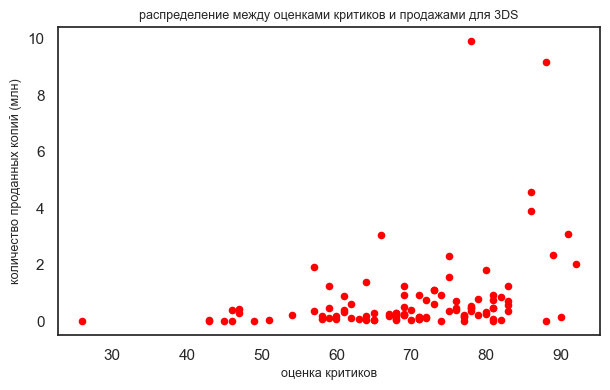

платформа PS3. корреляция с отзывами:
0.33


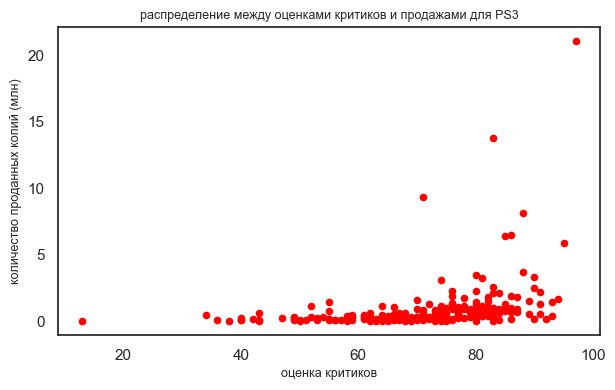

платформа PS4. корреляция с отзывами:
0.41


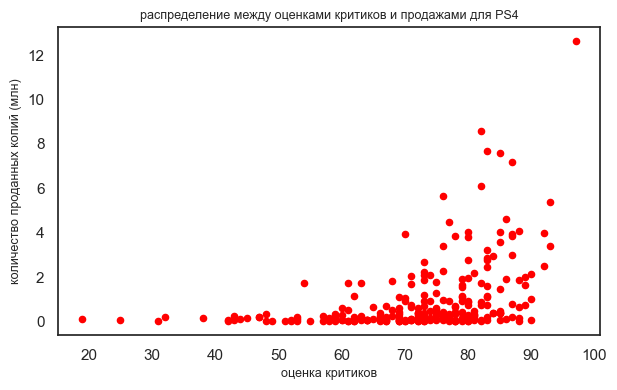

платформа X360. корреляция с отзывами:
0.36


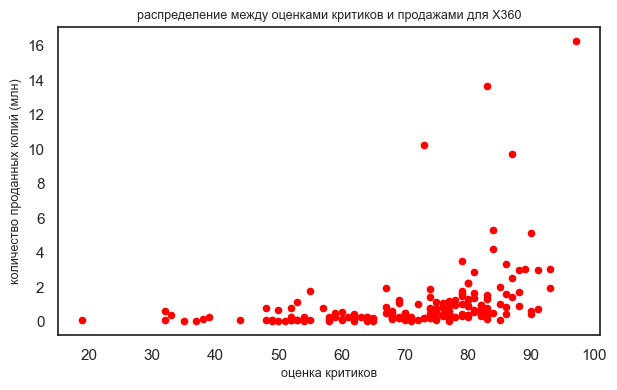

платформа XOne. корреляция с отзывами:
0.42


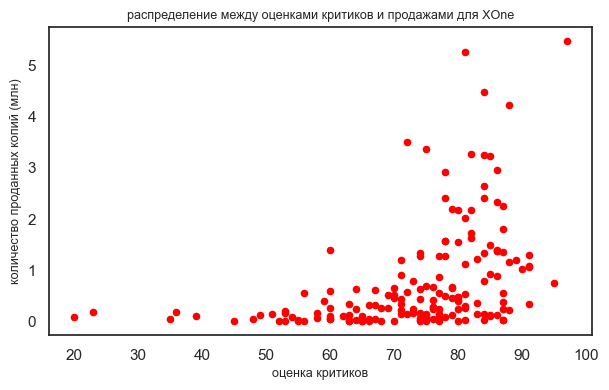

In [37]:
for name in young_5:
    (young_5_data.query('platform == @name and critic_score > -1')
     .plot(x='critic_score', 
           y='total_sales',
           kind='scatter',
           figsize=(7, 4),
           color='red')
    )
    plt.title(f'распределение между оценками критиков и продажами для {name}', fontsize=9)
    plt.xlabel('оценка критиков', fontsize=9)
    plt.ylabel('количество проданных копий (млн)', fontsize=9)
    print(f"платформа {name}. корреляция с отзывами:")
    print(young_5_data.query('platform == @name and critic_score > -1')['critic_score']
          .corr(young_5_data.query('platform == @name and critic_score > -1')['total_sales']).round(2))
    plt.show()

на всех графиках наблюдается незначительная корреляция между оценкой и уровнем продаж, причем у платформ `XOne` и `PS4` она выражена сильнее остальных. скорее всего, маркетинговые кампании по продвижению игр на данных платформах среди прочих инструментов продвижения используют оценки критиков, которым доверяют пользователи. 

### 3.5. распределение продаж по жанрам
теперь рассмотрим разброс продаж в зависимости от жанра игры. для начала построим столючатую диаграмму по сводной таблице, в которой для каждого жанра будет общая сумма продаж, охватывающая период 2012-2016:

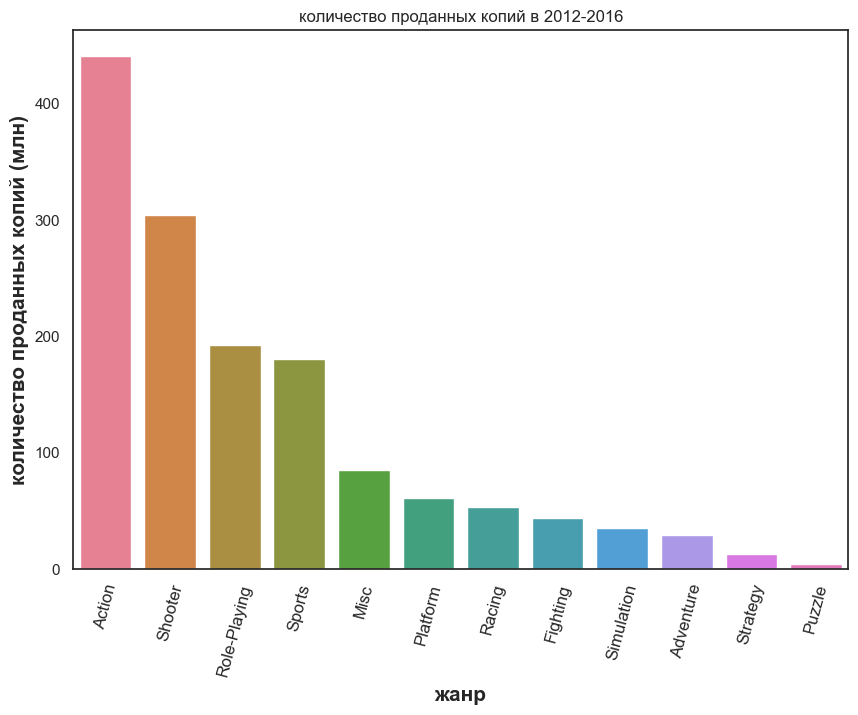

In [65]:
genre_sales = (fresh_data.pivot_table(index='genre',
                                  values='total_sales',
                                  aggfunc='sum',
                                  )
               .reset_index()
               .sort_values('total_sales', ascending=False)
                 )

sns.barplot(data=genre_sales, x='genre', y='total_sales', hue='genre')
sns.set(font_scale=1.2)
sns.set_theme(rc={'figure.figsize':(15, 7)}, style='white')
plt.title('количество проданных копий в 2012-2016')
plt.xlabel('жанр', fontsize=15, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=15, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.show()

топ-4 самых продаваемых жанров с заметным отрывом формируют экшены, шутеры, ролевые и спортивные игры. чтобы лучше понять специфику каждого жанра, посмотрим на распределение проданных копий внутри каждого жанра. для визуализации используем график `boxplot`, который наглядно отображает выбросы.

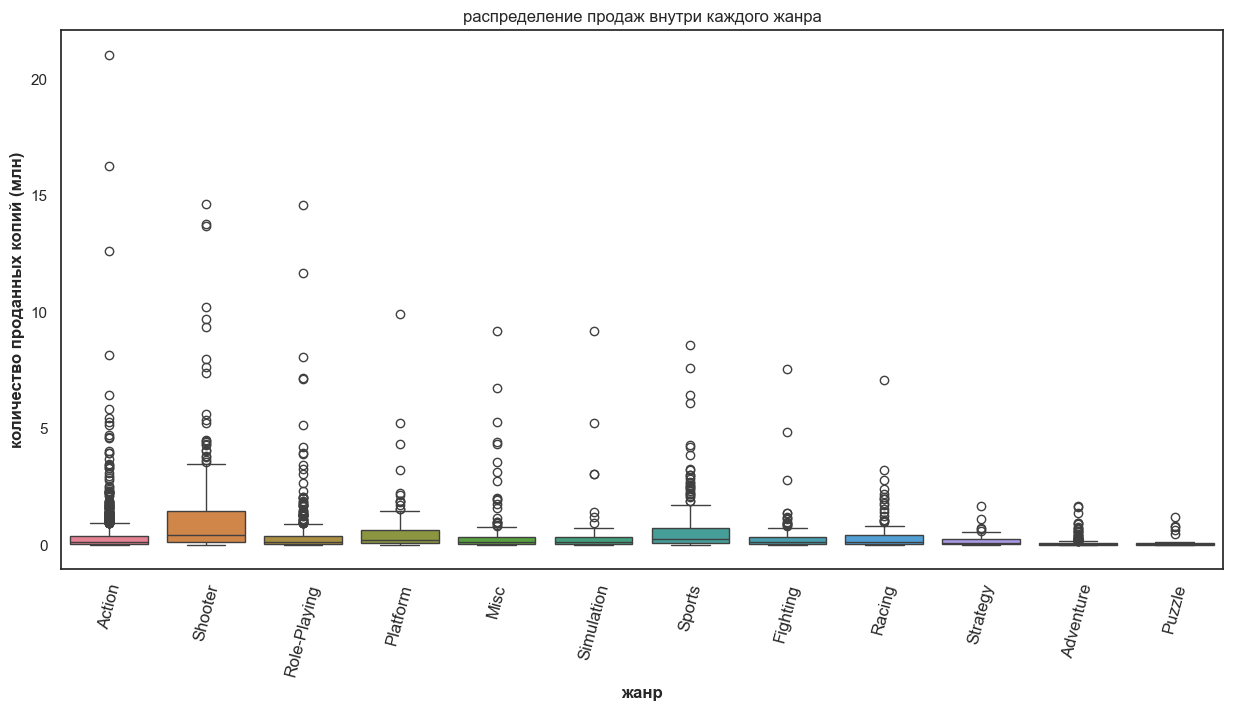

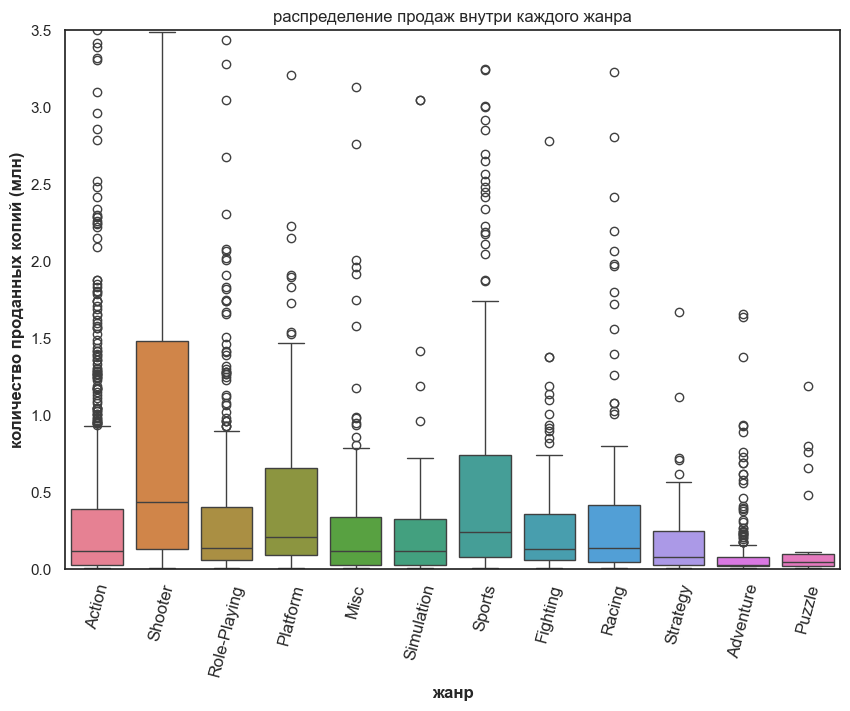

In [66]:
ax = sns.boxplot(data=fresh_data, x='genre', y='total_sales', hue='genre')
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')
plt.title('распределение продаж внутри каждого жанра')
plt.xlabel('жанр', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.show()

ax = sns.boxplot(data=fresh_data, x='genre', y='total_sales', hue='genre')
sns.set_theme(rc={'figure.figsize':(10, 7)}, style='white')
plt.title('распределение продаж внутри каждого жанра')
plt.xlabel('жанр', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.ylim(0, 3.5)
plt.show()

In [40]:
(fresh_data.pivot_table(index='genre', 
                          values='total_sales',
                          aggfunc='median')
 .sort_values('total_sales', ascending=False))

,total_sales
genre,
Shooter,0.440
Sports,0.240
Platform,0.210
Role-Playing,0.140
Racing,0.140
Fighting,0.130
Action,0.120
Misc,0.120
Simulation,0.120


мы видим, что продаваемость жанра экшн обеспечивается за счёт единичных выбросов, имеющих огромный спрос у пользователей. в то время как пользователи, предпочитающие шутеры, похоже, готовы играть в большую часть игр этого жанра. продажи спортивных и ролевых игр распределены подобно жанру экшен.  

также дополнительно рассмотрим динамику популярности жанров в пределах актуального промежутка 2012-2016

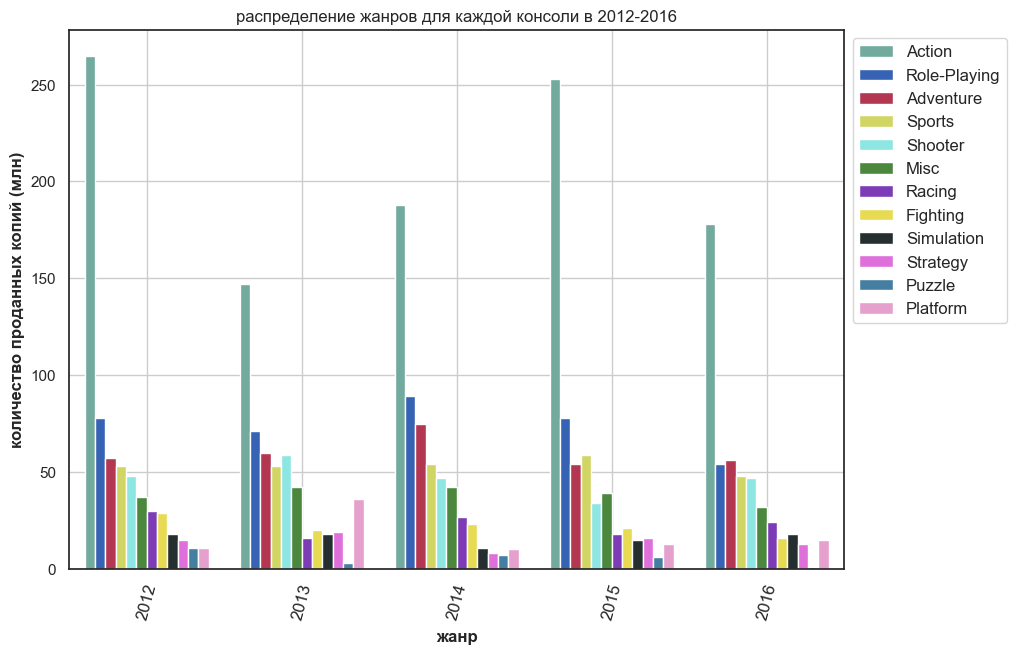

In [41]:
genre_dynamic = (fresh_data.pivot_table(index=['year_of_release', 'genre'], 
                                            values='name', 
                                            aggfunc='count')
                   .reset_index()
                   .sort_values('name', ascending=False)
                  )

colors = ["#69b3a2", "#225dc9", '#c92246', '#e3e851', '#7ff5f1', '#439431', '#7e28c9', '#ffef3b', '#243030', '#f25ced', '#3583b0', '#f095d1']
sns.set_palette(sns.color_palette(colors))

sns.barplot(data=genre_dynamic, x='year_of_release', y='name', hue='genre')
sns.set(font_scale=1.2)
sns.set_theme(rc={'figure.figsize':(18, 9)}, style='white')
plt.title('распределение жанров для каждой консоли в 2012-2016')
plt.xlabel('жанр', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=12, fontweight='bold')
plt.xticks(size=12, rotation=75)
plt.legend(fontsize='medium', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

на графике прослеживаются колебания в количестве выпускаемых игр жанра экшн, однако, коговорить о тенденции на снижение популярности рано. в данном случае полезно было бы изучить факторы, которые могут формировать волнообразную динамику: например, дополнительные релизы для новых игровых платформ, наличие кассовой игры, которая задаёт тренд (а значит, выпускаются подобные, но менее успешные проекты).  

также мы наблюдаем постепенный прирост в релизах ролевых и спортивных игр и незначительные колебания в жанре шутер.

### 3.6. распределение продаж по платформам

проведём аналогичные малипуляции для отображения распределения продаж по игровым платформам.

In [42]:
platform_genres = (fresh_data.pivot_table(index=['genre', 'platform'], 
                                            values='total_sales', 
                                            aggfunc='sum')
                   .reset_index()
                   .sort_values('total_sales', ascending=False)
                  )

platform_genres.head(15)

,genre,platform,total_sales
3,Action,PS3,115.75
4,Action,PS4,96.10
83,Shooter,PS4,88.56
9,Action,X360,81.60
69,Role-Playing,3DS,79.30
86,Shooter,X360,72.70
82,Shooter,PS3,60.39
87,Shooter,XOne,60.33
103,Sports,PS4,55.61
0,Action,3DS,45.49


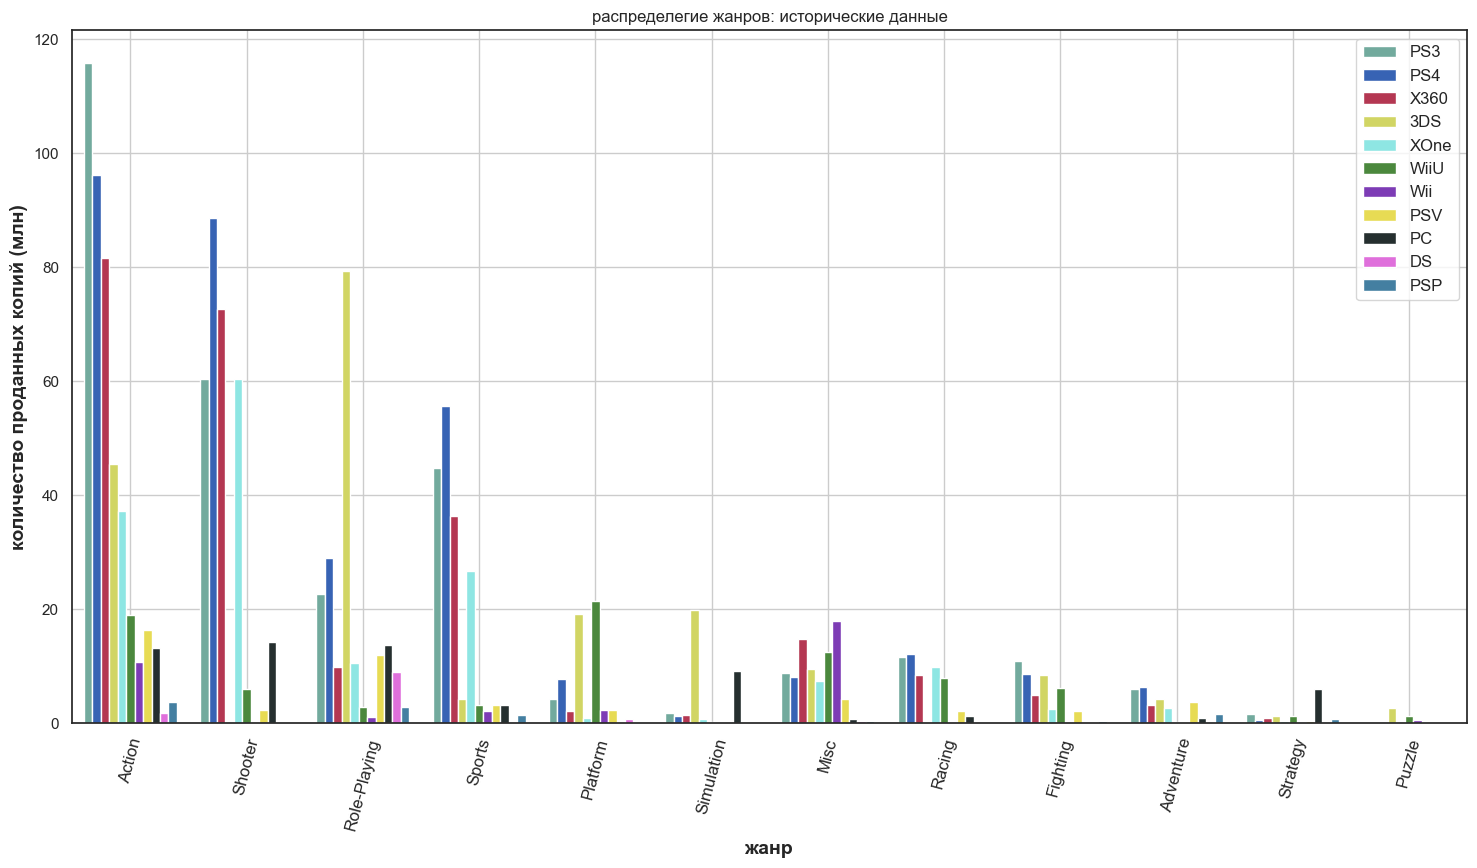

In [43]:
colors = ["#69b3a2", "#225dc9", '#c92246', '#e3e851', '#7ff5f1', '#439431', '#7e28c9', '#ffef3b', '#243030', '#f25ced', '#3583b0']
sns.set_palette(sns.color_palette(colors))

sns.barplot(data=platform_genres, x='genre', y='total_sales', hue='platform')
#sns.set(font_scale=1.2)
sns.set_theme(rc={'figure.figsize':(20, 10)}, style='white')
plt.title('распределегие жанров: исторические данные', fontsize=12)
plt.xlabel('жанр', fontsize=14, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=14, fontweight='bold')
plt.legend(fontsize='medium', loc='upper right')
plt.xticks(size=12, rotation=75)
plt.grid(True)
plt.show()

график выявил любопытную особенность консоли `3DS`: ни спортивные игры, ни шутеры здесь не популярны, а вот ролевые игры, наоборот. лидируют. также среди пользователей `XOne` шутеры значительно популярнее экшенов, а спортивные игры попялурнее ролевых. такие особенности обязательно следует учитывать, прогнозируя ожидаемую прибыль от игр.

**Промежуточный вывод**  
мы определили, что наиболее популярными жанрами являются экшены, шутеры и ролевые игры. однако, если мы хотим прогнозировать продажи для отдельно взятой платформы, следует отталкиваться не от общей динамики продаж, а от особенностей конкретной модели. возможно, техические характеристики, либо дизайн консолей обесречивают поплярность некоторых игр. 

## 4. Портрет пользователя

в этой части мы будем составлять примерный портрет пользователя из кпждого региона (NA, EU, JP, OTHER). какие именно показатели мы рассмотрим:
* топ-5 платформ в каждом из регионов
* жанры, популярные в каждом из регионов
* влияние рейтинга ESRB на продажи в отдельном регионе  

### 4.1. популярные консоли
воспользуемся срезом данных за 2012-2016 годы, который мы подготовили ранее.

In [44]:
fresh_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
16,Grand Theft Auto V,PS3,2013,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
23,Grand Theft Auto V,X360,2013,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,-1.0,-1.0,unknown,14.63
33,Pokemon X/Pokemon Y,3DS,2013,Role-Playing,5.28,4.19,4.35,0.78,-1.0,-1.0,unknown,14.60
34,Call of Duty: Black Ops II,PS3,2012,Shooter,4.99,5.73,0.65,2.42,83.0,5.3,M,13.79
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown,0.01
16707,Aiyoku no Eustia,PSV,2014,Misc,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown,0.01
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown,0.01
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.00,0.00,0.01,0.00,-1.0,-1.0,unknown,0.01


2885 наблюдений, вполне достаточно для сравнительного анализа по регионам. теперь составим сводную таблицу, в которой отобразим общие продажи по каждой платформе в каждом отдельно взятом регионе:

In [45]:
fresh_data_region = (fresh_data.pivot_table(index='platform',
                                            values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                            aggfunc='sum'                                           
                                           )
                     .reset_index()
                     .melt(id_vars=['platform'])
                     .sort_values('value', ascending=False)
                    )

fresh_data_region.head(10)

,platform,variable,value
4,PS4,eu_sales,141.09
31,X360,na_sales,140.05
26,PS4,na_sales,108.74
3,PS3,eu_sales,106.86
25,PS3,na_sales,103.38
32,XOne,na_sales,93.12
11,3DS,jp_sales,87.79
9,X360,eu_sales,74.52
22,3DS,na_sales,55.31
10,XOne,eu_sales,51.59


теперь визуализируем полученные данные, чтобы было проще определить топ-5 консолей для каждого региона.

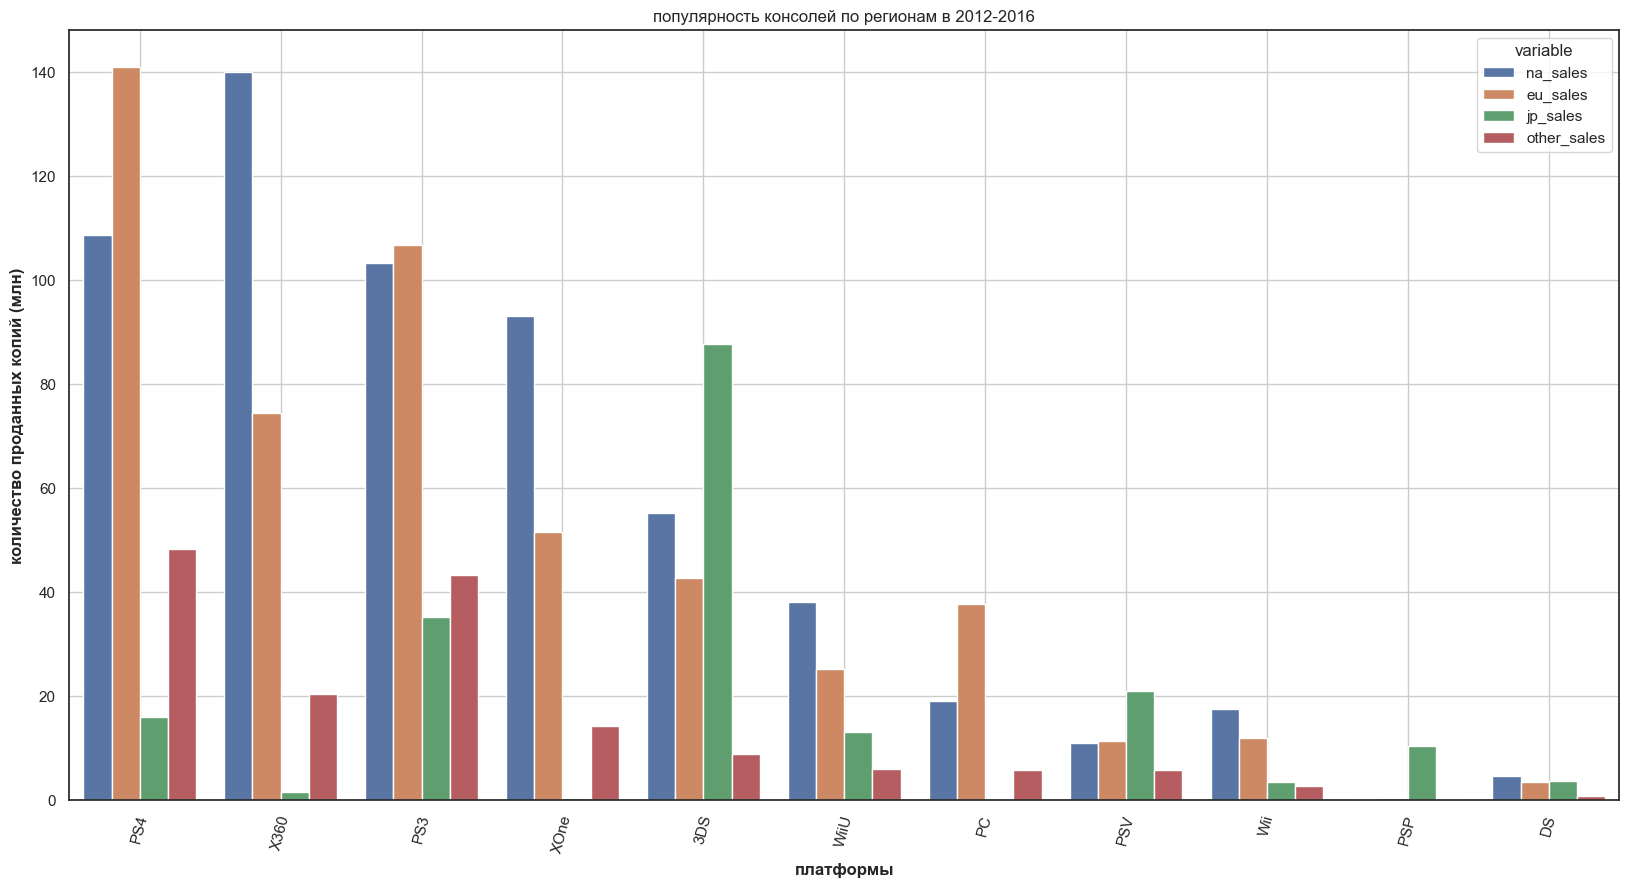

In [46]:
ax = sns.barplot(x=fresh_data_region.platform,
                 y=fresh_data_region.value,
                 hue=fresh_data_region.variable,
                 hue_order=['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
                 )
sns.set_theme(rc={'figure.figsize':(12, 8)}, style='white')
plt.title('популярность консолей по регионам в 2012-2016')
plt.xlabel('платформы', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=12, fontweight='bold')
plt.xticks(rotation=75)
plt.grid(True)
plt.show()

популярность платформ неодинакова в различных регионах:

* na_sales: X360, PS4, PS, XOne, 3DS
* eu_sales: PS4, PS3, X360, XOne, 3DS
* jp_sales: 3DS, PS3, PSV, PS4, WiiU
* other: PS4, PS3, X360, XOne, 3DS

в распределении популярности консолей наиболее необычен рынок Японии: платфора X360 и XOne там почти не популярны. и, напротив, платформы `3DS`, `PSV` и `PSP` ещё востребованы и показывают более высокий уровень продаж, чем в остальных регионах.

### 4.2. популярные жанры
теперь рассмотрим, как варьируется популярность игровых жанров от региона к региону. созраним в отдельный вспомогательный датасет на основе среза данных об играх, выпущенных а 2012-2016 годах:

In [47]:
fresh_data_genre = (fresh_data.pivot_table(index='genre',
                                            values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                            aggfunc='sum'                                           
                                           )
                     .reset_index()
                     .melt(id_vars=['genre'])
                     .sort_values('value', ascending=False)
                    )

fresh_data_genre.head(10)

,genre,variable,value
24,Action,na_sales,177.84
0,Action,eu_sales,159.34
32,Shooter,na_sales,144.77
8,Shooter,eu_sales,113.47
34,Sports,na_sales,81.53
10,Sports,eu_sales,69.09
19,Role-Playing,jp_sales,65.44
31,Role-Playing,na_sales,64.00
12,Action,jp_sales,52.80
36,Action,other_sales,51.14


визуализируем полученное распределение жанров по регионам с помощью круговых диаграм. но для начала проведём дополнительную категоризацию жанров: оставим топ-5, а остальные жанры обозначим как `Other` и запишем данные в новый столбец с помощью срециальной функции.  
перед тем как производить категоризацию, зафиксируем количество игр каждого жанра в датасете:

In [48]:
fresh_data['genre'].value_counts()

genre
Action          1031
Role-Playing     370
Adventure        302
Sports           267
Shooter          235
Misc             192
Racing           115
Fighting         109
Platform          85
Simulation        80
Strategy          71
Puzzle            28
Name: count, dtype: int64

In [49]:
# создадим список с перечнем популярных жанров.
popular_genres = ['Action', 'Role-Playing', 'Adventure', 'Shooter', 'Sports']

# напишем функцию для одной строки, 
def genre_grouped(row):
    genre = row['genre']
    if genre in popular_genres:
        return genre
    else:
        return 'Other'

# применим функцию и проверим результат, сравнив количество игр топовых жанров до и после
fresh_data.loc[:, 'genre_group'] = fresh_data.apply(genre_grouped, axis=1)
fresh_data['genre_group'].value_counts()

genre_group
Action          1031
Other            680
Role-Playing     370
Adventure        302
Sports           267
Shooter          235
Name: count, dtype: int64

новый столбец создан корректно. на его основе создадим сводную таблицу, с помощью которой построим графики:

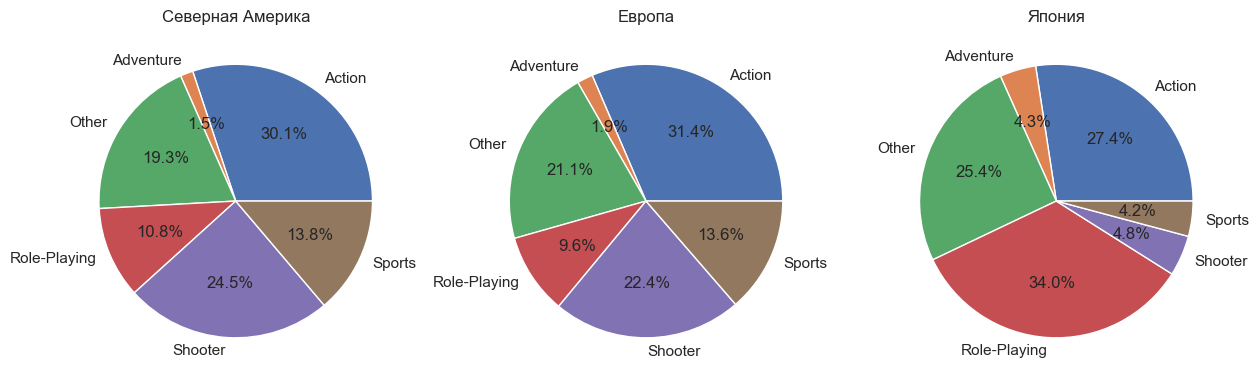

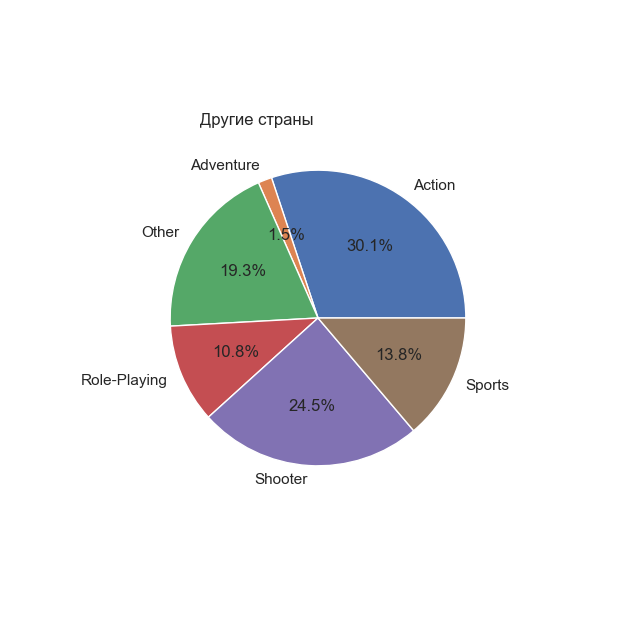

In [50]:
subset = fresh_data.pivot_table(index='genre_group', 
                          values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'], 
                          aggfunc='sum').reset_index()

fig, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=(15,15))

labels = subset['genre_group']
values = subset['na_sales']
ax1.pie(values, labels=labels, autopct = '%1.1f%%')
ax1.set_title('Северная Америка')

labels = subset['genre_group']
values = subset['eu_sales']
ax2.pie(values, labels=labels, autopct = '%1.1f%%')
ax2.set_title('Европа')

labels = subset['genre_group']
values = subset['jp_sales']
ax3.pie(values, labels=labels, autopct = '%1.1f%%')
ax3.set_title('Япония')
plt.show()

labels = subset['genre_group']
values = subset['na_sales']
plt.pie(values, labels=labels, radius=0.6, autopct = '%1.1f%%')
plt.title('Другие страны', x=0.4, y=0.8)
plt.show() 

лидирующим жанром во всех регионах, кроме Японии, является экшн, затем шутеры и спортивные игры. японские пользватели гораздо чаще прочих выбирают ролевые игры.

### 4.3. влияние рейтинга
для начала давайте ознакомимся с тем, какие значения рейтинга присутствуют в датасете и как их расшифровывать.

In [51]:
data['rating'].unique()

array(['E', 'unknown', 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'],
      dtype=object)

* `E` &mdash; еveryone, то есть для всех возрастных категорий.
* `K-A` &mdash; kids to аdults, старая маркировка рейтинга E, существовавшая до 1998 года
* `EC` &mdash; еarly childhood, игры безопасные для детей от 3 лет
* `E10+` &mdash; еveryone 10 and older, для всех старше 10 лет
* `T` &mdash; teen, игры для подростков от 13 лет
* `M` &mdash; mature, игры для возрастной категории старше 17 лет
* `AO` &mdash; adults only, только для взрослых старше 18 лет
* `RP` &mdash; rating pending, игра ожидает заключения ESRB о возрастной категории 
* `unknowon` &mdash; игры, не имеющие жанровой маркировки

при аналзе продаж в разрезе рейтинга следует учесть, что продажи игр категории `E` и `K-A` можно суммировать.

также логично предположить, что игры для детей (наиболее юной возрастной категории `EC` и `E10+`, скорее всего, будут более скромные продажи в силу меньшего запроса со стороны покупателя).

рейтинг `RP` в рамках настоящего исследования можно объединить с рейтингом `unknown`. давайте посмотрим, много ли в исходном датасете игр, имеющих такую маркировку:

In [52]:
data.query('rating == "RP"')

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14270,Supreme Ruler: Cold War,PC,2011,Strategy,0.0,0.03,0.0,0.01,63.0,6.8,RP,0.04


всего одна игра, для платформы `PC`, рассматирвать которую в данном исследовании мы не будем. удалять позицию из датасета не будем.

перед тем как переходить к анализу, следует отметить, что рейтинг ESRB признан, внедрён и используется в Канаде, Мексике и США. то есть в других регионах (EU, JP, OTHER) данная система рейтингов может не оказывать влияния на выбор покупателя: человек может быть плохо знаком с маркировкой и просто не обратит на неё внимания. 

проверим наше предположение с помощью сводной таблицы и графика

In [53]:
fresh_data_rating = (fresh_data.pivot_table(index='rating',
                                            values=['na_sales', 'eu_sales', 'jp_sales', 'other_sales'],
                                            aggfunc='sum'                                           
                                           )
                     .reset_index()
                     .melt(id_vars=['rating'])
                     .sort_values('value', ascending=False)
                    )

fresh_data_rating

,rating,variable,value
12,M,na_sales,231.57
2,M,eu_sales,193.96
10,E,na_sales,114.37
0,E,eu_sales,113.03
9,unknown,jp_sales,108.84
14,unknown,na_sales,103.31
4,unknown,eu_sales,91.50
11,E10+,na_sales,75.70
13,T,na_sales,66.02
17,M,other_sales,63.38


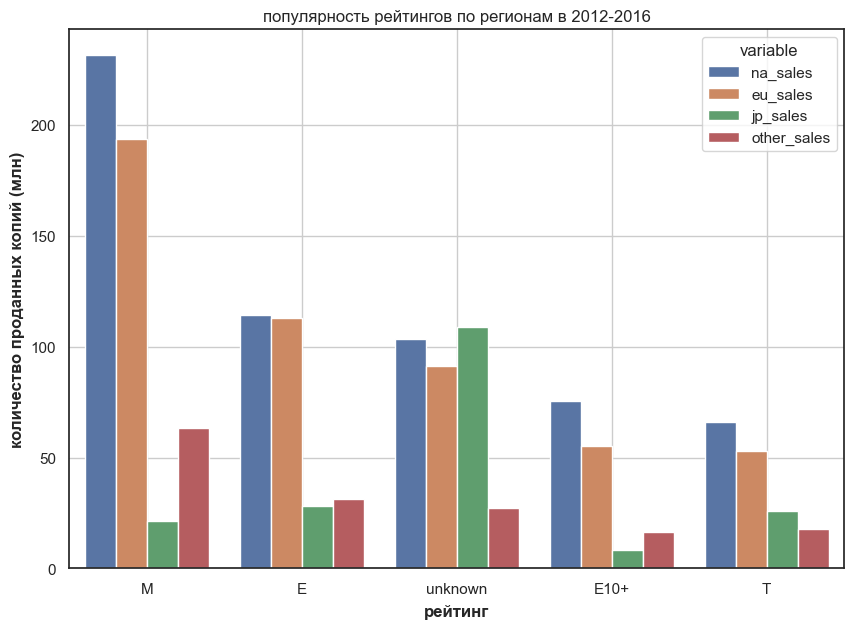

In [67]:
ax = sns.barplot(x=fresh_data_rating.rating,
                 y=fresh_data_rating.value,
                 hue=fresh_data_rating.variable,
                 hue_order=['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
                 )
sns.set_theme(rc={'figure.figsize': (12, 8)}, style='white')
plt.title('популярность рейтингов по регионам в 2012-2016')
plt.xlabel('рейтинг', fontsize=12, fontweight='bold', labelpad=6)
plt.ylabel('количество проданных копий (млн)', fontsize=12, fontweight='bold')
plt.grid(True)
plt.show()

из графика видно, что в Европе и Северой Америке прослеживается общий паттерн: наиболее популярными являются игры с рейтингом `М` (от 17 лет), следом идут игры для всех (`Е`), потом &mdash; для детей от десяти лет и, наконец, игры для детей от 13. 

продажи в прочих регионах демонстрируют похожую динамику с разницей в том, что категория `T` здесь популярнее категории `E10+`, однако общее количество продаж по каждой категории, а также разрыв между ними не позволяют говорить о явной тенденции. 

в Японии наиболее популярными являются игры с рейтингом `M`, все прочие рейтинги имеют примерно одинаковый вес. однако следует учесть, что маркировка ESRB может не считываться покупателем, т.к. в Японии врозрастными рейтингами для игр занимается собственная организация CERO, у которой другой подход к ранжированию.

игры неопределённого рейтинга не будем брать в расчёт, так как в данном случае непонятно: игра не имеет маркировки рейтинга в принципе, или маркировка есть, но выставлена согласно другим стандартам.

также отметим, что игры для малышей (`EC`), а также игры для взрослой аудитории 18+ (`AO`) в принципе не представлены среди игр, продававшихся между 2012-2016 годами. и у первой, и у второй возрастной категории есть свои потребители. можно предположить, что игры с данным рейтингом мигрировали на другие площадки. 

**Промежуточные выводы**

мы проанализировали игры в разрезе нескольких характеристик относительно региональной принадлежности, чтобы составить общие портреты пользователей.

* `Северная америка`  
  пользователь из этого региона, скорее всего, играет с консоли Xbox 360, либо PS4. платформа PS3 по-пренему остаётся популярной, но, возможно в скором времени вытеснит Xbox One. особым спросом пользуются экшн-иры и шутеры, ожидаемая возрастная категори игр `M` и `Е`

* `Европа`  
  еропейсий покупатель, скорее всего, является пользователем `PS4`, консоль предыдущего поколения `PS3` тоже довольно популярна. популярные в Америке платыормы `Xbox One` и `Xbox 360` вызывают зачительно меньший интерес. европейский пользователь предпочитает экшн-игры и шутеры, ожидаемая возрастная категория `M` и `E`

* `Япония`  
  пользователь из Японии, скорее всего, предпочитает игры для платформы `3DS`. в отличие от друних регионов, здесь востребованы в первую очередь ролевые игры, потом :&mdash; экшен. предпочитаемый рейтинг установить не удалось, т.к. в Японии в ходу другая система возрастного ранжирования игр.

* `Остальные регионы`  
    в целом по остальному миру пользователи склонны демонстрировать такие же предпочтения, как и европейцы: популярна платформа `PS4`, пока ещё не сдаёт позиции `PS3`. жанровые предпочтения сосредоточены вокруг экшн-игр и шутеров. наиболее вероятно, что пользователи других регионо предпочитают игры категории `M`. прочие возрастные категории одинаково популярны.

## 5. Проверка гипотез

в данной части исследования мы проверим две гипотезы, поступившие от бизнеса:

1. Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
2. Средние пользовательские рейтинги жанров Action и Sports разные.

обе гипотезы будем проверять при пороговом значении `alpha=0.05`

### 5.1. гипотеза №1. рейтинги платформ `Xbox One` и `PC`
за нулевую гипотезу примем предположение о равенстве, за альтернативную &mdash; предположение о том, что рейтинги различаются:
* $H_0$: Средние пользовательские рейтинги платформ Xbox One и PC одинаковые
* $H_1$: Средние пользовательские рейтинги платформ Xbox One и PC не равны

так как бизнес интересует сам факт равенства, проверять гипотезу будем с помощью двустороннего t-теста.  
для проведения анализа подготовим две выборки: игры на платформе `XOne` и `PC`, в обоих случаях будем отбирать только те наблюдения, у которых пользовательский рейтинг отличен от -1.

In [55]:
xone_scores = data.query('platform == "XOne" and user_score > -1 and year_of_release >= 2012')
pc_scores = data.query('platform == "PC" and user_score > -1 and year_of_release >= 2012')

# чтобы принять решение о равенстве выборок и корректно задать атрибут equal_var, 
# сравним описательные статистики обеих выборок:

print(f"статистики пользовательских рейтингов для XOne: \n {xone_scores['user_score'].describe()} \n"
      f"~~~~~~~ \n"
      f"статистики пользовательских рейтингов для РС: \n {pc_scores['user_score'].describe()}"
     )

статистики пользовательских рейтингов для XOne: 
 count    182.000000
mean       6.521429
std        1.380941
min        1.600000
25%        5.800000
50%        6.800000
75%        7.500000
max        9.200000
Name: user_score, dtype: float64 
~~~~~~~ 
статистики пользовательских рейтингов для РС: 
 count    206.000000
mean       6.428641
std        1.664465
min        1.400000
25%        5.500000
50%        6.800000
75%        7.700000
max        9.300000
Name: user_score, dtype: float64


объём выборок и распреденение подвозяют нам прибегнуть к t-тесту. применительно к данной гипотезе, мы бдем проводить двустороннй тест для двух независимых выборок. 

размер выборок, так же как и стандартное отклонение, незначительно различаются. для большей точности примем `equal_var=False`

In [56]:
alpha = 0.05

results = st.ttest_ind(xone_scores['user_score'],
                       pc_scores['user_score'],
                       equal_var=False,
                       alternative='two-sided'
                      )

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

0.5489537965134912
Не получилось отвергнуть нулевую гипотезу


нулевую гипотезу не отвергаем, у нас есть основатия полагать, что рейтинги платформ равны при заданном уровне значимости `.05`

### 5.2. гипотеза №2. рейтинги жанров `Action` и `Sports`
за нулевую гипотезу примем предположение о равенстве, за альтернативную &mdash; предположение о том, что рейтинги различаются:
* $H_0$: Средние пользовательские рейтинги жанров Action и Sports одинаковые
* $H_1$: Средние пользовательские рейтинги жанров Action и Sports не равны

так как бизнес интересует сам факт различия, так же как и в первом случае, проверять гипотезу будем с помощью двустороннего t-теста. для проведения анализа из периода 2012-2016 вычленим две выборки: игры в жанре Action и игры в жанре Sport:

In [57]:
action_scores = data.query("genre == 'Action' and year_of_release >= 2012 and user_score > -1")
sports_scores = data.query("genre == 'Sports' and year_of_release >= 2012 and user_score > -1")

# чтобы принять решение о равенстве выборок и корректно задать атрибут equal_var, 
# сравним описательные статистики обеих выборок:

print(f"статистики пользовательских рейтингов для жанра Action: \n{action_scores['user_score'].describe()} \n"
      f"~~~~~~~ \n"
      f"статистики пользовательских рейтингов для жанра Sports: \n{sports_scores['user_score'].describe()}"
     )

статистики пользовательских рейтингов для жанра Action: 
count    523.000000
mean       6.825048
std        1.374440
min        1.600000
25%        6.250000
50%        7.100000
75%        7.800000
max        9.100000
Name: user_score, dtype: float64 
~~~~~~~ 
статистики пользовательских рейтингов для жанра Sports: 
count    194.000000
mean       5.455670
std        1.743142
min        0.200000
25%        4.300000
50%        5.750000
75%        6.800000
max        8.800000
Name: user_score, dtype: float64


объём выборок и распреденение подвозяют нам прибегнуть к t-тесту. применительно к данной гипотезе, мы бдем проводить двустороннй тест для двух независимых выборок. 

выборки значительно отличаются по объёму, также разнятся значения стандартного отклонения. для большей точности примем `equal_var=False`

In [58]:
alpha = 0.05

results = st.ttest_ind(action_scores['user_score'],
                       sports_scores['user_score'],
                       equal_var=False,
                       alternative='two-sided'
                      )

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

5.989458066467418e-20
Отвергаем нулевую гипотезу


отвергаем нулевую гипотезу и допускаем, что при уровне значимости .05 рейтинги жанров `Action` и `Sports` не равны.

**Промежуточный вывод**  
на этапе исследования оценок мы установили, что выборочные средние имеют нормальное распределение, а объём выборок значительно превышает минимальные требования. исходя из этого мы заключили что оценки пользователей в нашем датасете имеют нормальное распределение и для проверки гипотез можно применить и t-тест.

так как в обоих случаяз бизнес интересовал сам факт равенства или не равенства, мы выбрали проверку двусторонней гипотезы. также мы решили, что пользователи разных платформ формируют две независимые выборки (для сравнения: зависимыми будут быборки пользователей PS3 и PS4 &mdash; часть юзеров перейдёт с консоли старого поколения на новую консоль того же производителя). аналогичное решение мы приняли для двух разных жанров.

на завершающем этапе исследования мы проверили две гипотезы о средних пользовательских рейтингах игр для двух разных жанров и двух разных платформ. с большой долей уверенности полагать, что:

* средние пользовательские рейтинги платформ Xbox One и PC равны
* средние пользовательские рейтинги жанров Action и Sports не равны

данную информацию можно учитывать при выборе продуктов для продвижения и выборе маркетинговых кампаний.


## 6. Выводы

в рамках работы с данными мы провели предобработку, в результате которой былы удалены дубликаты, а также устранены пропущенные значения:
* в случае с ключевыми характеристиками наблюдений (название игры и год выпуска) мы приняли решение об удалении строк, содержащих данные пропуски, что было необходимо для дальнейшего статистического анализа и возможно благодаря небольшой доли таких наблюдений. 
* в случае с большой долей пропусков в важных характеристиках (рейтинг, оценка критиков и пользователей) мы приняли решение оставить строки в датасете, но не заменять пропуски на наиболее частотные показатели внутры типовой группы. вместо этого мы заполнили пустоты на стандартные значения, отличные от реальных показателей. для рейтинга это метка `unknown`, для оценок пользователей и критиков это значение `-1`.

очистив данные, мы вычислили общую количество продаж для каждого наблюдения и добавили информацию в основной датасет.

в рамках исследовательского анализа данных мы подстветили следующие моменты, которые могут быть полезны для бизнеса:
* резкое падение количества релизов игр стабилизировалось к 2012 году. временной отрезок 2012-2016 годов хорошо подходит для исследования рынка и прогнозирования продаж.
* в результате анализа динамики прибыльности платформ нам удалось установить приблизительный срок жизни игровой платформы на рынке, составивший `7 лет`. данная информация поможет коллегам  определить потенциальную прибыльность платформы в ближайшие 2-3 года. наиболее выгодными являются консоли, запуск которых состоялся за 2-3 года до проводимого анализа: примерно столько времени нужно игровой платформе, чтобы набрать мощность по продажам игр.
* по результатам предыдущих двух этапов мы топ-5 популярных платформ: '3DS', 'PS3', 'PS4', 'X360', 'XOne'.
* анализ ключевой группы выявил слабую корреляцию между количеством продаж и оценкой критиков. это значит, что при планировании развития бизнеса можно учитывать данный фактор, но основывать на нём соновную маркетинговую стратегию не стоит. что касается оценки пользовательского рейтинга, то мы не выявили корреляцию ни в ключевой группе, ни среди всех платформ, для которых выпускались игры в 2012-2016 годах.
* также мы проанализировали распределение продаж в зависимости от жанра и платформы. в результате исследования мы выяснили, что популярность одного и того же жара может вариьироваться в зависимости от платформы. например, для `PS3` самые породаваемые игры &mdash; в жанре экшн. а на более новой `PS4` чаще играют в шутеры. таким образом, выбирая игры для продвижения на рынке, всегда нужно учитывать платформу.

также мы подготовили для бизнеса собирательные портреты пользователей в зависимости от региона:
* `Северная америка`: популярны консоли Xbox 360 или PS4. платформа PS3 по-пренему интересна, но, возможно в скором времени её вытеснит Xbox One. особым спросом пользуются экшн-иры и шутеры, ожидаемая возрастная категори игр `M` и `Е`

* `Европа`: популярна `PS4` и консоль предыдущего поколения `PS3`. европейский пользователь предпочитает экшн-игры и шутеры, ожидаемая возрастная категория `M` и `E`

* `Япония`: популярна `3DS`. здесь востребованы в первую очередь ролевые игры и только потом :&mdash; экшен. предпочитаемый рейтинг установить не удалось, т.к. в Японии в ходу другая система возрастного ранжирования игр.

* `Остальные регионы`: в целом по остальному миру пользователи склонны демонстрировать такие же предпочтения, как и европейцы: популярна платформа `PS4`; `PS3` ещё держит аудиторию. жанровые предпочтения сосредоточены вокруг экшн-игр и шутеров. наиболее вероятно, что пользователи других регионо предпочитают игры категории `M`. предпочтетия по играм остальныж возрастных категория выражены неярко.

для составления более полного портрета пользователя было бы интересго собрать информацию о распределении игроков по полу, возрасту и социальному положению. данная информация существенно поможет в составлении более точного прогноза.

и, наконец, мы проверили поступившие от бизнеса гипотезы и можем сделать следующее заключение:
* средние пользовательские рейтинги игр для платформ Xbox One и PC равны. 
* средние пользовательские рейтинги игр жанров Action и Sports на равны.   

ранее в иссоедовании мы выявили, что между оценками пользователей и количеством проданных игр нет сильной взаимосвязи, однако можно предположить, что оценка пользователей складывается под влиянием оценки критиков с отклонением в большую сторону. таким образом при учитывании прочих ключевых факторов (срок жизни платформы, динамика популярности жанров), пользовательский рейтинг можно учитывать в планировании продвижения продукта.

**какие игры стоит продвигать в следующем сезоне при ограниченном рекламном бюджете:**
* выбираем общую игру для Северной Америки и Европы.
    * жанры: экшн (если анонсирован релиз долгожданной новики), либо шутер (как наиболее надёжный жанр)  
    * консоль: PS4, популярна в обоих регионах
    * рейтинг: 17+  &mdash; охватываем максимальную аудиторию.  
    
* выбираем игру для Северной Америки.
     * жанр:  экшн (если анонсирован релиз долгожданной новики), либо шутер
     * консоль: Xbox One
     * рейтинг: 17+
     
если заявлен релиз ожидаемой новики в жанре ролевых игр и рекламного бюжета хватает на ещё одну кампанию:    
* выбираем одну игру для Японии:
    * жанр: ролевая игра
    * консоль: 3DS
    * рейтинг: 17+